In [67]:
# Importing libraries and supress warnings
import folium
import itertools
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import time
import warnings
from geopy.geocoders import Nominatim
from IPython.display import display
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, pairwise_distances, roc_auc_score, silhouette_score, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Patch
from termcolor import colored
warnings.filterwarnings("ignore")
plt.style.use('default')

# Loading the dataset, Clean up column names by removing any leading or trailing spaces, Transforming and Creating some variables (Dictionary)
data = pd.read_csv(r"C:\Users\claud\OneDrive\Desktop\DataMining\homework\Project\shopping_trends.csv")
data.columns = data.columns.str.strip().str.replace(' ', '_'); data = data.drop(columns=['Customer_ID'], errors='ignore'); 
print('Lines and Columns:', data.shape)
freq_map = {"Weekly": 52, "Fortnightly": 26, "Bi-Weekly": 26, "Monthly": 12, "Quarterly": 4, "Every 3 Months": 4, "Annually": 1}; 
data["Frequency_Purch_per_year"] = data["Frequency_of_Purchases"].map(freq_map); 
data['Subscription_Num'] = data['Subscription_Status'].map({'Yes': 1, 'No': 0})


# Reading dataset after inclusion of Coordinates (see this logic in another file)
data = pd.read_csv(r"C:\Users\claud\OneDrive\Desktop\DataMining\homework\Project\dataset_with_coordinates.csv"); 
# Creating dictionary to map region
state_to_region = {
    "Maine": "Northeast", "Massachusetts": "Northeast", "Rhode Island": "Northeast", 
    "New Hampshire": "Northeast", "New York": "Northeast", "New Jersey": "Northeast", 
    "Vermont": "Northeast", "Pennsylvania": "Northeast", "Connecticut": "Northeast",
    
    "Illinois": "Midwest", "Indiana": "Midwest", "Iowa": "Midwest", "Kansas": "Midwest",
    "Michigan": "Midwest", "Minnesota": "Midwest", "Missouri": "Midwest", "Nebraska": "Midwest",
    "North Dakota": "Midwest", "Ohio": "Midwest", "South Dakota": "Midwest", "Wisconsin": "Midwest",
    
    "Alabama": "South", "Arkansas": "South", "Delaware": "South", "Florida": "South", 
    "Georgia": "South", "Kentucky": "South", "Louisiana": "South", "Maryland": "South", 
    "Mississippi": "South", "North Carolina": "South", "Oklahoma": "South", 
    "South Carolina": "South", "Tennessee": "South", "Texas": "South", 
    "Virginia": "South", "West Virginia": "South",
    
    "Alaska": "West", "Arizona": "West", "California": "West", "Colorado": "West", 
    "Hawaii": "West", "Idaho": "West", "Montana": "West", "Nevada": "West", 
    "New Mexico": "West", "Oregon": "West", "Utah": "West", 
    "Washington": "West", "Wyoming": "West"}
data['Region'] = data['Location'].map(state_to_region)
print(data[['Location', 'Region']].head())

# Summarize dataset
missing_data, desc_stats = data.isnull().mean() * 100, data.describe().T; 
summary_df = pd.concat([data.dtypes.rename('Data Type'), missing_data.rename('Missing (%)'), data.nunique().rename('Unique Values'), 
                        desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']], data.mode().iloc[0].rename('Mode')], axis=1); 
print("\nDataset Summary:\n"); display(summary_df)


Lines and Columns: (3900, 18)
        Location     Region
0       Kentucky      South
1          Maine  Northeast
2  Massachusetts  Northeast
3   Rhode Island  Northeast
4         Oregon       West

Dataset Summary:



,Data Type,Missing (%),Unique Values,count,mean,std,min,25%,50%,75%,max,Mode
Age,int64,0.0,53,3900.0,44.068462,15.207589,18.000000,31.000000,44.000000,57.000000,70.000000,69.0
Gender,object,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
Item_Purchased,object,0.0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blouse
Category,object,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clothing
Purchase_Amount_(USD),int64,0.0,81,3900.0,59.764359,23.685392,20.000000,39.000000,60.000000,81.000000,100.000000,32
Location,object,0.0,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Montana
Size,object,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M
Color,object,0.0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Olive
Season,object,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring
Review_Rating,float64,0.0,26,3900.0,3.749949,0.716223,2.500000,3.100000,3.700000,4.400000,5.000000,3.4


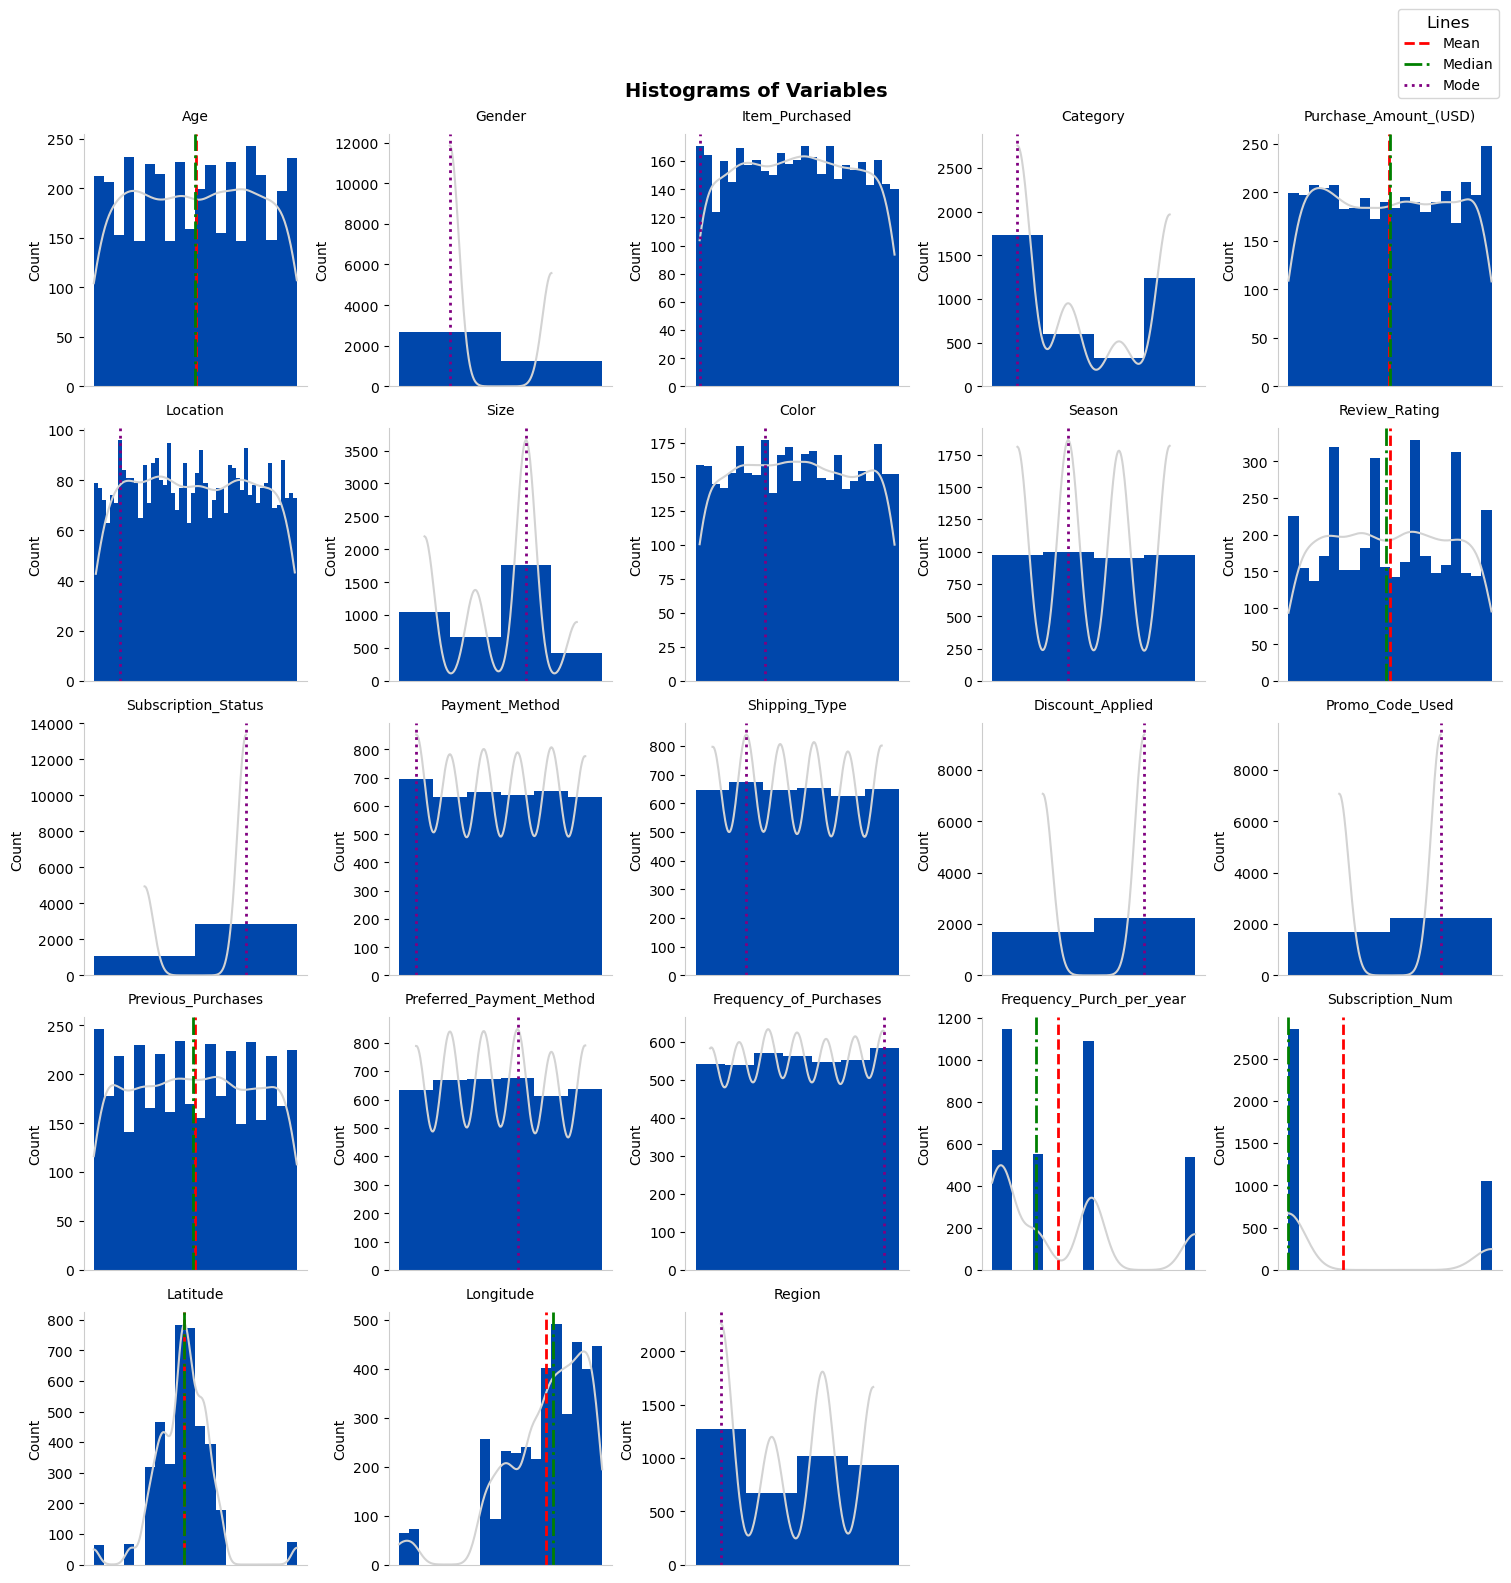

In [68]:

# Making a copy of the dataset and remove unnecessary columns for this analysis
data_copy = data.copy()
to_drop = ['Subscription_Status', 'Location', 'Frequency_of_Purchases']
data_copy = data_copy.drop(columns=to_drop, errors='ignore')

# Plotting histograms of variables and dataset lines
num_cols, cols_per_row = len(data.columns), 5
rows = math.ceil(num_cols / cols_per_row)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 3), constrained_layout=True)
fig.suptitle("Histograms of Variables", fontsize=14, weight='bold')
axes = axes.flatten()
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=20, ax=axes[i], kde=True, color='#0047AB', edgecolor=None, alpha=1)
    if data[column].dtype != 'object': 
        mean_value, median_value = data[column].mean(), data[column].median()
        axes[i].axvline(mean_value, color='r', linestyle='--', linewidth=2, label='Mean')
        axes[i].axvline(median_value, color='g', linestyle='-.', linewidth=2, label='Median')
    else: 
        mode = data[column].mode()
        if not mode.empty:
            mode_value = mode[0]
            axes[i].axvline(mode_value, color='purple', linestyle=':', linewidth=2, label='Mode')   
    axes[i].set_title(f"{column}", fontsize=10, pad=10)
    axes[i].set_xlabel("")
    axes[i].set_xticks([])
    if len(axes[i].lines) > 0:
        kde_line = axes[i].lines[0]
        kde_line.set_color('#D3D3D3')
for j in range(num_cols, len(axes)):
    axes[j].set_visible(False)
handles = [plt.Line2D([0], [0], color='r', linestyle='--', linewidth=2, label='Mean'),
    plt.Line2D([0], [0], color='g', linestyle='-.', linewidth=2, label='Median'),
    plt.Line2D([0], [0], color='purple', linestyle=':', linewidth=2, label='Mode')]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1.05), fontsize=10, title="Lines", title_fontsize=12)
for j in range(num_cols):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['left'].set_color('#CCCCCC')
    axes[j].spines['bottom'].set_color('#CCCCCC')
plt.savefig('grafico1.png', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
# Identifying outliers for all variables, handling categorical and numerical data differently, and summarize the results
outliers_summary = []; 
for col in data.columns: 
    if data[col].dtype == 'object': 
        counts = data[col].value_counts(); mean, std = counts.mean(), counts.std() 
        z_scores = (counts - mean) / std; outliers = z_scores[abs(z_scores) > 3] 
        message = f"Outliers found: {', '.join(outliers.index)}" if not outliers.empty else "No representative outliers found"
    else: 
        mean, std = data[col].mean(), data[col].std(); z_scores = (data[col] - mean) / std 
        outliers = data[col][abs(z_scores) > 3] 
        message = f"Outliers found: {len(outliers)} values" if not outliers.empty else "No representative outliers found"
    outliers_summary.append({'Variable': col, 'Message': message})
outliers_summary_df = pd.DataFrame(outliers_summary); print("Outliers Summary for All Variables:\n"); display(outliers_summary_df)

Outliers Summary for All Variables:



,Variable,Message
0,Age,No representative outliers found
1,Gender,No representative outliers found
2,Item_Purchased,No representative outliers found
3,Category,No representative outliers found
4,Purchase_Amount_(USD),No representative outliers found
5,Location,No representative outliers found
6,Size,No representative outliers found
7,Color,No representative outliers found
8,Season,No representative outliers found
9,Review_Rating,No representative outliers found


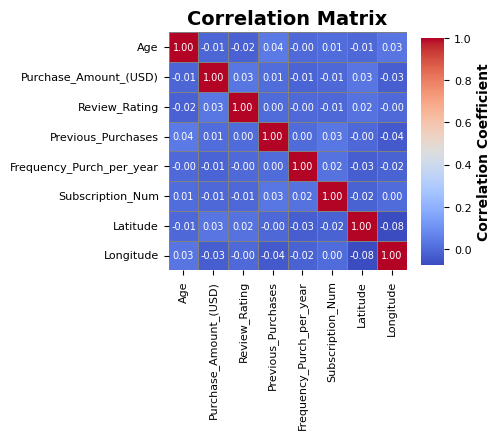

In [70]:
# Creating Correlation Matrix of numerical variables to check Subscription Correlation
plt.figure(figsize=(5, 5)); heatmap = sns.heatmap(data.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, linecolor='gray', annot_kws={"size": 7}, cbar_kws={'label': 'Correlation Coefficient','shrink': 0.65, 'aspect': 10}); cbar = heatmap.collections[0].colorbar; cbar.set_label('Correlation Coefficient', fontsize=10, weight='bold'); cbar.ax.tick_params(labelsize=8); heatmap.set_title("Correlation Matrix", fontsize=14, weight='bold'); heatmap.set_xlabel("", fontsize=8); heatmap.set_ylabel("", fontsize=8); heatmap.tick_params(axis='x', labelsize=8, rotation=90), heatmap.tick_params(axis='y', labelsize=8); plt.tight_layout(); plt.show()


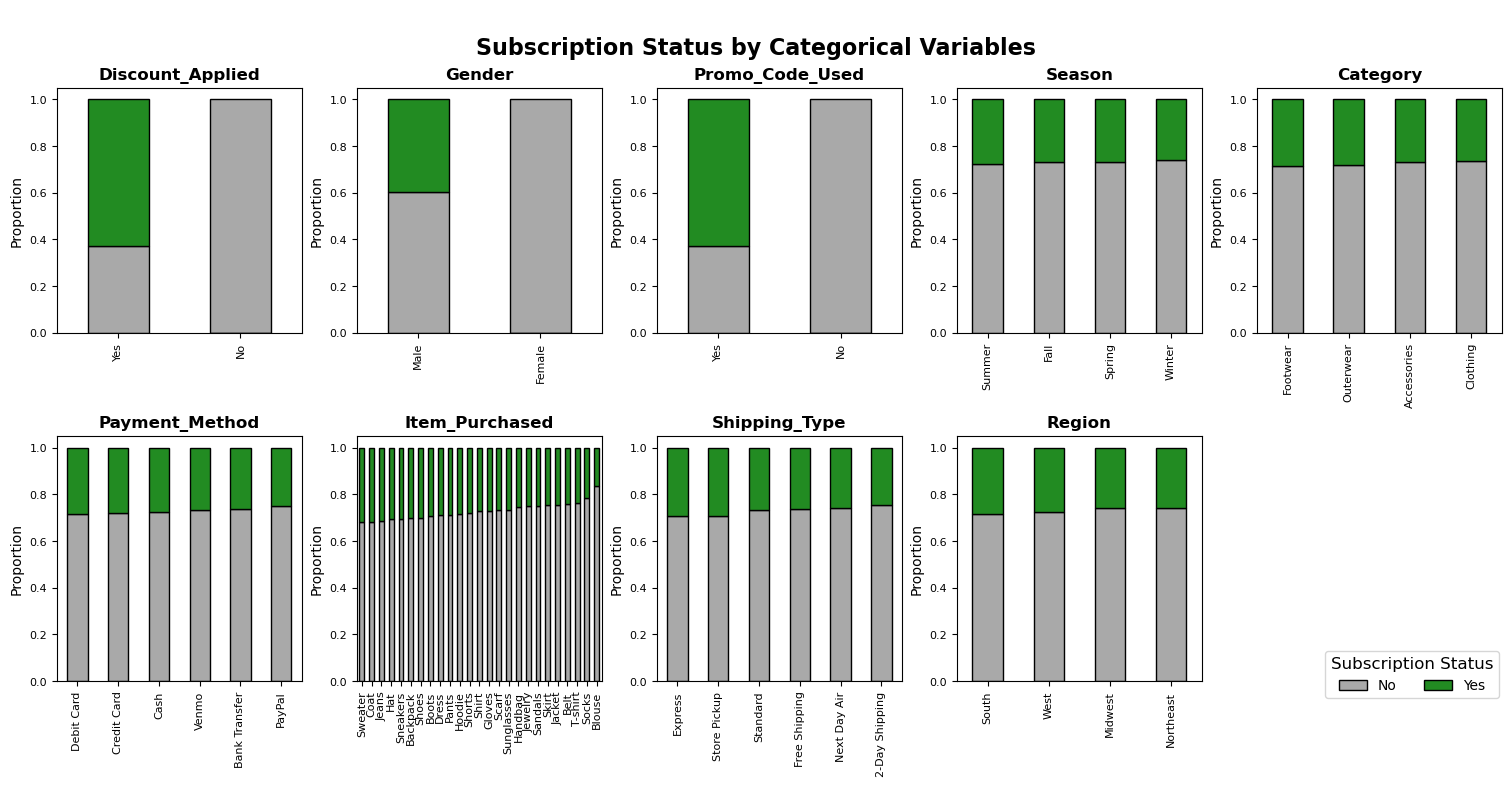

In [71]:
############################################ ANSWERING BUSINESS PROBLEM 1 - PART 1 ##########################################

# Verifiying proportion of Subscrition vs Categorical Variables
Categorical_variables = ["Discount_Applied", "Gender", "Promo_Code_Used", "Season", "Category", "Payment_Method", "Item_Purchased", "Shipping_Type", "Region"]; 
fig, axes = plt.subplots(7, 5, figsize=(15, 20), constrained_layout=True); axes = axes.flatten()
for i, var in enumerate(Categorical_variables):
    summary = data.groupby([var, 'Subscription_Status']).size().reset_index(name='Count')
    pivot = summary.pivot(index=var, columns='Subscription_Status', values='Count').fillna(0) 
    pivot_normalized = pivot.div(pivot.sum(axis=1), axis=0).sort_values(by='Yes', ascending=False) 
    pivot_normalized.plot(kind='bar', stacked=True, ax=axes[i], color=['#A9A9A9', '#228B22'], edgecolor='black', legend=False)
    axes[i].set_title(f'{var}', fontsize=12, weight='bold'); axes[i].set_xlabel('')
    axes[i].set_ylabel('Proportion', fontsize=10); axes[i].tick_params(axis='both', labelsize=8)
fig.suptitle("\nSubscription Status by Categorical Variables", fontsize=16, weight='bold') 
handles, labels = axes[0].get_legend_handles_labels(); fig.legend(handles, ['No', 'Yes'], title='Subscription Status', loc='lower right', bbox_to_anchor=(1, 0.65), ncol=2, fontsize=10, title_fontsize=12); 
if len(Categorical_variables) < len(axes): [fig.delaxes(axes[j]) for j in range(len(Categorical_variables), len(axes))]; plt.savefig('grafico2.png', dpi=300, bbox_inches='tight'); plt.show()


In [72]:
##################### ANSWERING BUSINESS PROBLEM 1 - PART 2 - BACKWARD SELECTION (LESS COMPUTATION COST) ####################

# Converting remaining categorical variables into dummies
categorical_cols = data_copy.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Converting categorical variables: {categorical_cols.tolist()}")
data_copy = pd.get_dummies(data_copy, dtype='int64', drop_first=False)


# Converting boolean columns to integers
bool_cols = data_copy.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print(f"Converting boolean columns to integers: {bool_cols.tolist()}")
    data_copy[bool_cols] = data_copy[bool_cols].astype('int64')


# Separating dependent and independent variables
y = data_copy['Subscription_Num']  
X = data_copy.drop(columns=['Subscription_Num'])  # Independent variables


# Normalizing numeric variables in X
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# Confirming that Subscription_Num is binary (or remains binary)
if not set(y.unique()).issubset({0, 1}):
    raise ValueError("The 'Subscription_Num' variable is not binary (0 and 1). Check the data!")


# Checking column types after preprocessing
print("\nColumn Types After Preprocessing:")
print(data_copy.dtypes.value_counts())
non_numeric_cols = data_copy.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print("\nNon-Numeric Columns Found:", non_numeric_cols.tolist())
    raise ValueError("There are still non-numeric columns in the dataset.")


# Selecting independent and dependent variables
exclude_columns = ['Subscription_Num']  
predictors = [col for col in data_copy.columns if col not in exclude_columns]
X = data_copy[predictors]
y = data_copy['Subscription_Num']


# Verify data consistency
def check_data_integrity(X, y):
    """Function to verify data integrity before modeling"""
    if X.isnull().sum().any() or y.isnull().any():
        raise ValueError("There are null values in X or y. Check the data.")
    if not np.issubdtype(y.dtype, np.number):
        raise ValueError("The target variable (y) is not numeric. Check the data.")
    if not np.all([np.issubdtype(X[col].dtype, np.number) for col in X.columns]):
        raise ValueError("Some independent variables in X are not numeric.")
    print("Data verified: No issues found.")
check_data_integrity(X, y)


# Spliting the dataset into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


# Backward elimination function
def backward_elimination(all_variables, train_X, train_y, valid_X, valid_y, significance_level=0.05):
    remaining_variables = list(all_variables)
    best_model = None
    best_variables = None
    while len(remaining_variables) > 0:
        X_train = sm.add_constant(train_X[remaining_variables])
        X_valid = sm.add_constant(valid_X[remaining_variables])
        model = sm.OLS(train_y, X_train).fit()
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            worst_variable = p_values.idxmax()
            print(f"Removing variable: {worst_variable} with p-value {max_p_value:.4f}")
            remaining_variables.remove(worst_variable)
        else:
            best_model = model
            best_variables = remaining_variables
            break
    return best_model, best_variables


# Running backward elimination
best_model_backward, best_variables_backward = backward_elimination(train_X.columns, train_X, train_y, valid_X, valid_y)


# Displaying the final model summary
print("\nBackward Elimination - Final Result\n")
print("Selected Variables:", best_variables_backward)
print(best_model_backward.summary())


Converting categorical variables: ['Gender', 'Item_Purchased', 'Category', 'Size', 'Color', 'Season', 'Payment_Method', 'Shipping_Type', 'Discount_Applied', 'Promo_Code_Used', 'Preferred_Payment_Method', 'Region']

Column Types After Preprocessing:
int64      95
float64     3
Name: count, dtype: int64
Data verified: No issues found.
Removing variable: Latitude with p-value 0.9933
Removing variable: Item_Purchased_Sweater with p-value 0.9883
Removing variable: Color_Yellow with p-value 0.9856
Removing variable: Color_Lavender with p-value 0.9761
Removing variable: Category_Outerwear with p-value 0.9770
Removing variable: Payment_Method_PayPal with p-value 0.9711
Removing variable: Shipping_Type_Standard with p-value 0.9654
Removing variable: Item_Purchased_Pants with p-value 0.9251
Removing variable: Item_Purchased_Backpack with p-value 0.9238
Removing variable: Item_Purchased_Hat with p-value 0.9591
Removing variable: Item_Purchased_Coat with p-value 0.9405
Removing variable: Color_Sil

In [73]:
############################### ANSWERING BUSINESS PROBLEM 1 - PART 4 - LASSO CV #####################################

# Spliting the data again using ALL variables
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(X, y, test_size=0.4, random_state=1)

# Configuring LassoCV
lasso = LassoCV(cv=5, random_state=1)

# Fitting the model
lasso.fit(train_X_lasso, train_y_lasso)

# Predictions on the validation set
lasso_preds = lasso.predict(valid_X_lasso)

# Lasso metrics
lasso_r2 = r2_score(valid_y_lasso, lasso_preds)
lasso_mse = mean_squared_error(valid_y_lasso, lasso_preds)

# Displaying results
print("\nLassoCV - Results:")
print(f"R² on the validation set: {lasso_r2:.4f}")
print(f"MSE on the validation set: {lasso_mse:.4f}")
print(f"Lasso model coefficients:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef:.4f}")

# Displaying variables selected by Lasso (coefficient != 0)
selected_features = [f for f, c in zip(X.columns, lasso.coef_) if c != 0]
print(f"\nVariables Selected by Lasso: {selected_features}")



LassoCV - Results:
R² on the validation set: 0.5005
MSE on the validation set: 0.1017
Lasso model coefficients:
Age: -0.0001
Purchase_Amount_(USD): -0.0000
Review_Rating: -0.0000
Previous_Purchases: 0.0005
Frequency_Purch_per_year: 0.0005
Latitude: -0.0007
Longitude: 0.0001
Gender_Female: -0.0000
Gender_Male: 0.0000
Item_Purchased_Backpack: -0.0000
Item_Purchased_Belt: -0.0000
Item_Purchased_Blouse: -0.0000
Item_Purchased_Boots: -0.0000
Item_Purchased_Coat: -0.0000
Item_Purchased_Dress: 0.0000
Item_Purchased_Gloves: 0.0000
Item_Purchased_Handbag: 0.0000
Item_Purchased_Hat: 0.0000
Item_Purchased_Hoodie: 0.0000
Item_Purchased_Jacket: -0.0000
Item_Purchased_Jeans: 0.0000
Item_Purchased_Jewelry: 0.0000
Item_Purchased_Pants: 0.0000
Item_Purchased_Sandals: 0.0000
Item_Purchased_Scarf: -0.0000
Item_Purchased_Shirt: 0.0000
Item_Purchased_Shoes: 0.0000
Item_Purchased_Shorts: -0.0000
Item_Purchased_Skirt: -0.0000
Item_Purchased_Sneakers: -0.0000
Item_Purchased_Socks: -0.0000
Item_Purchased_Sung

In [74]:
################################### ANSWERING BUSINESS PROBLEM 1 - PART 5 - LOGISTIC REGRESSION ###############################

print("Unique values in Subscription_Num:", data_copy['Subscription_Num'].unique())

# 1. Confirming that Subscription_Num is binary
if not set(data_copy['Subscription_Num'].unique()).issubset({0, 1}):
    raise ValueError("The variable 'Subscription_Num' is not binary (0 and 1). Please check the data!")

# 2. Explanatory variables (X) and dependent variable (y)
X = data_copy.drop(columns=['Subscription_Num'])
y = data_copy['Subscription_Num']

# 3. Function to evaluate the logistic regression model
def evaluate_logistic_regression(features, X, y, test_size=0.4):
    train_X, valid_X, train_y, valid_y = train_test_split(X[features], y, test_size=test_size, random_state=1)
    log_model = LogisticRegression(random_state=1, max_iter=1000)
    log_model.fit(train_X, train_y)
    predictions = log_model.predict(valid_X)
    probas = log_model.predict_proba(valid_X)[:, 1]
    accuracy = accuracy_score(valid_y, predictions)
    auc_roc = roc_auc_score(valid_y, probas)
    cm = confusion_matrix(valid_y, predictions)
    report = classification_report(valid_y, predictions, target_names=["Did Not Subscribe", "Subscribed"])
    return {'model': log_model, 'accuracy': accuracy, 'roc_auc': auc_roc, 'confusion_matrix': cm, 'classification_report': report}

# Scenarios for evaluation
lasso_selected_features = ['Age', 'Purchase_Amount_(USD)', 'Previous_Purchases', 'Frequency_Purch_per_year', 'Latitude', 'Longitude', 
                           'Shipping_Type_Express', 'Shipping_Type_Next Day Air', 'Shipping_Type_Store Pickup', 'Discount_Applied_No', 
                           'Discount_Applied_Yes', 'Preferred_Payment_Method_Debit Card', 'Region_Midwest']
backward_selected_features = ['Gender_Female', 'Gender_Male', 'Color_Purple', 'Season_Fall', 'Season_Spring', 'Season_Summer', 
                              'Season_Winter', 'Shipping_Type_Express', 'Shipping_Type_Store Pickup', 'Discount_Applied_Yes', 'Promo_Code_Used_No', 'Region_Midwest']
combined_unique_features = list(set(lasso_selected_features + backward_selected_features))
manual_selected_features = ['Age', 'Purchase_Amount_(USD)', 'Review_Rating', 'Frequency_Purch_per_year', 'Latitude', 'Longitude']

# Evaluating each scenario
lasso_results = evaluate_logistic_regression(lasso_selected_features, X, y)
backward_results = evaluate_logistic_regression(backward_selected_features, X, y)
combined_results = evaluate_logistic_regression(combined_unique_features, X, y)
manual_results = evaluate_logistic_regression(manual_selected_features, X, y)

# 6. Comparing results
print("*" * 150)
comparison = pd.DataFrame({"Scenario": ["LassoCV", "Backward Selection", "Combined", "Manual"],
    "Accuracy": [lasso_results['accuracy'], backward_results['accuracy'], combined_results['accuracy'], manual_results['accuracy']],
    "AUC-ROC": [lasso_results['roc_auc'], backward_results['roc_auc'], combined_results['roc_auc'], manual_results['roc_auc']] })
print("\n*** Final Comparison of Variable Selections for the 4 Scenarios (LassoCV, Backward Selection, LassoCV+Backward, Manual) ***")
print(comparison)

# 7. Displaying classification reports
print("*" * 150)
print("\n*** Classification Report - LassoCV ***")
print(lasso_results['classification_report'])
print("\nVariables used: ", lasso_selected_features)
print("*" * 150)
print("\n*** Classification Report - Backward Selection ***")
print(backward_results['classification_report'])
print("\nVariables used: ", backward_selected_features)
print("*" * 150)
print("\n*** Classification Report - Combined Lasso CV + Backward Selection ***")
print(combined_results['classification_report'])
print("\nVariables used: ", combined_unique_features)
print("*" * 150)
print("\n*** Classification Report - Manual ***")
print(manual_results['classification_report'])
print("\nVariables used: ", manual_selected_features)
print("*" * 150)


Unique values in Subscription_Num: [1 0]
******************************************************************************************************************************************************

*** Final Comparison of Variable Selections for the 4 Scenarios (LassoCV, Backward Selection, LassoCV+Backward, Manual) ***
             Scenario  Accuracy   AUC-ROC
0             LassoCV  0.827564  0.894201
1  Backward Selection  0.833333  0.889270
2            Combined  0.826923  0.892957
3              Manual  0.715385  0.487980
******************************************************************************************************************************************************

*** Classification Report - LassoCV ***
                   precision    recall  f1-score   support

Did Not Subscribe       0.95      0.80      0.87      1116
       Subscribed       0.64      0.90      0.75       444

         accuracy                           0.83      1560
        macro avg       0.80      0.85     

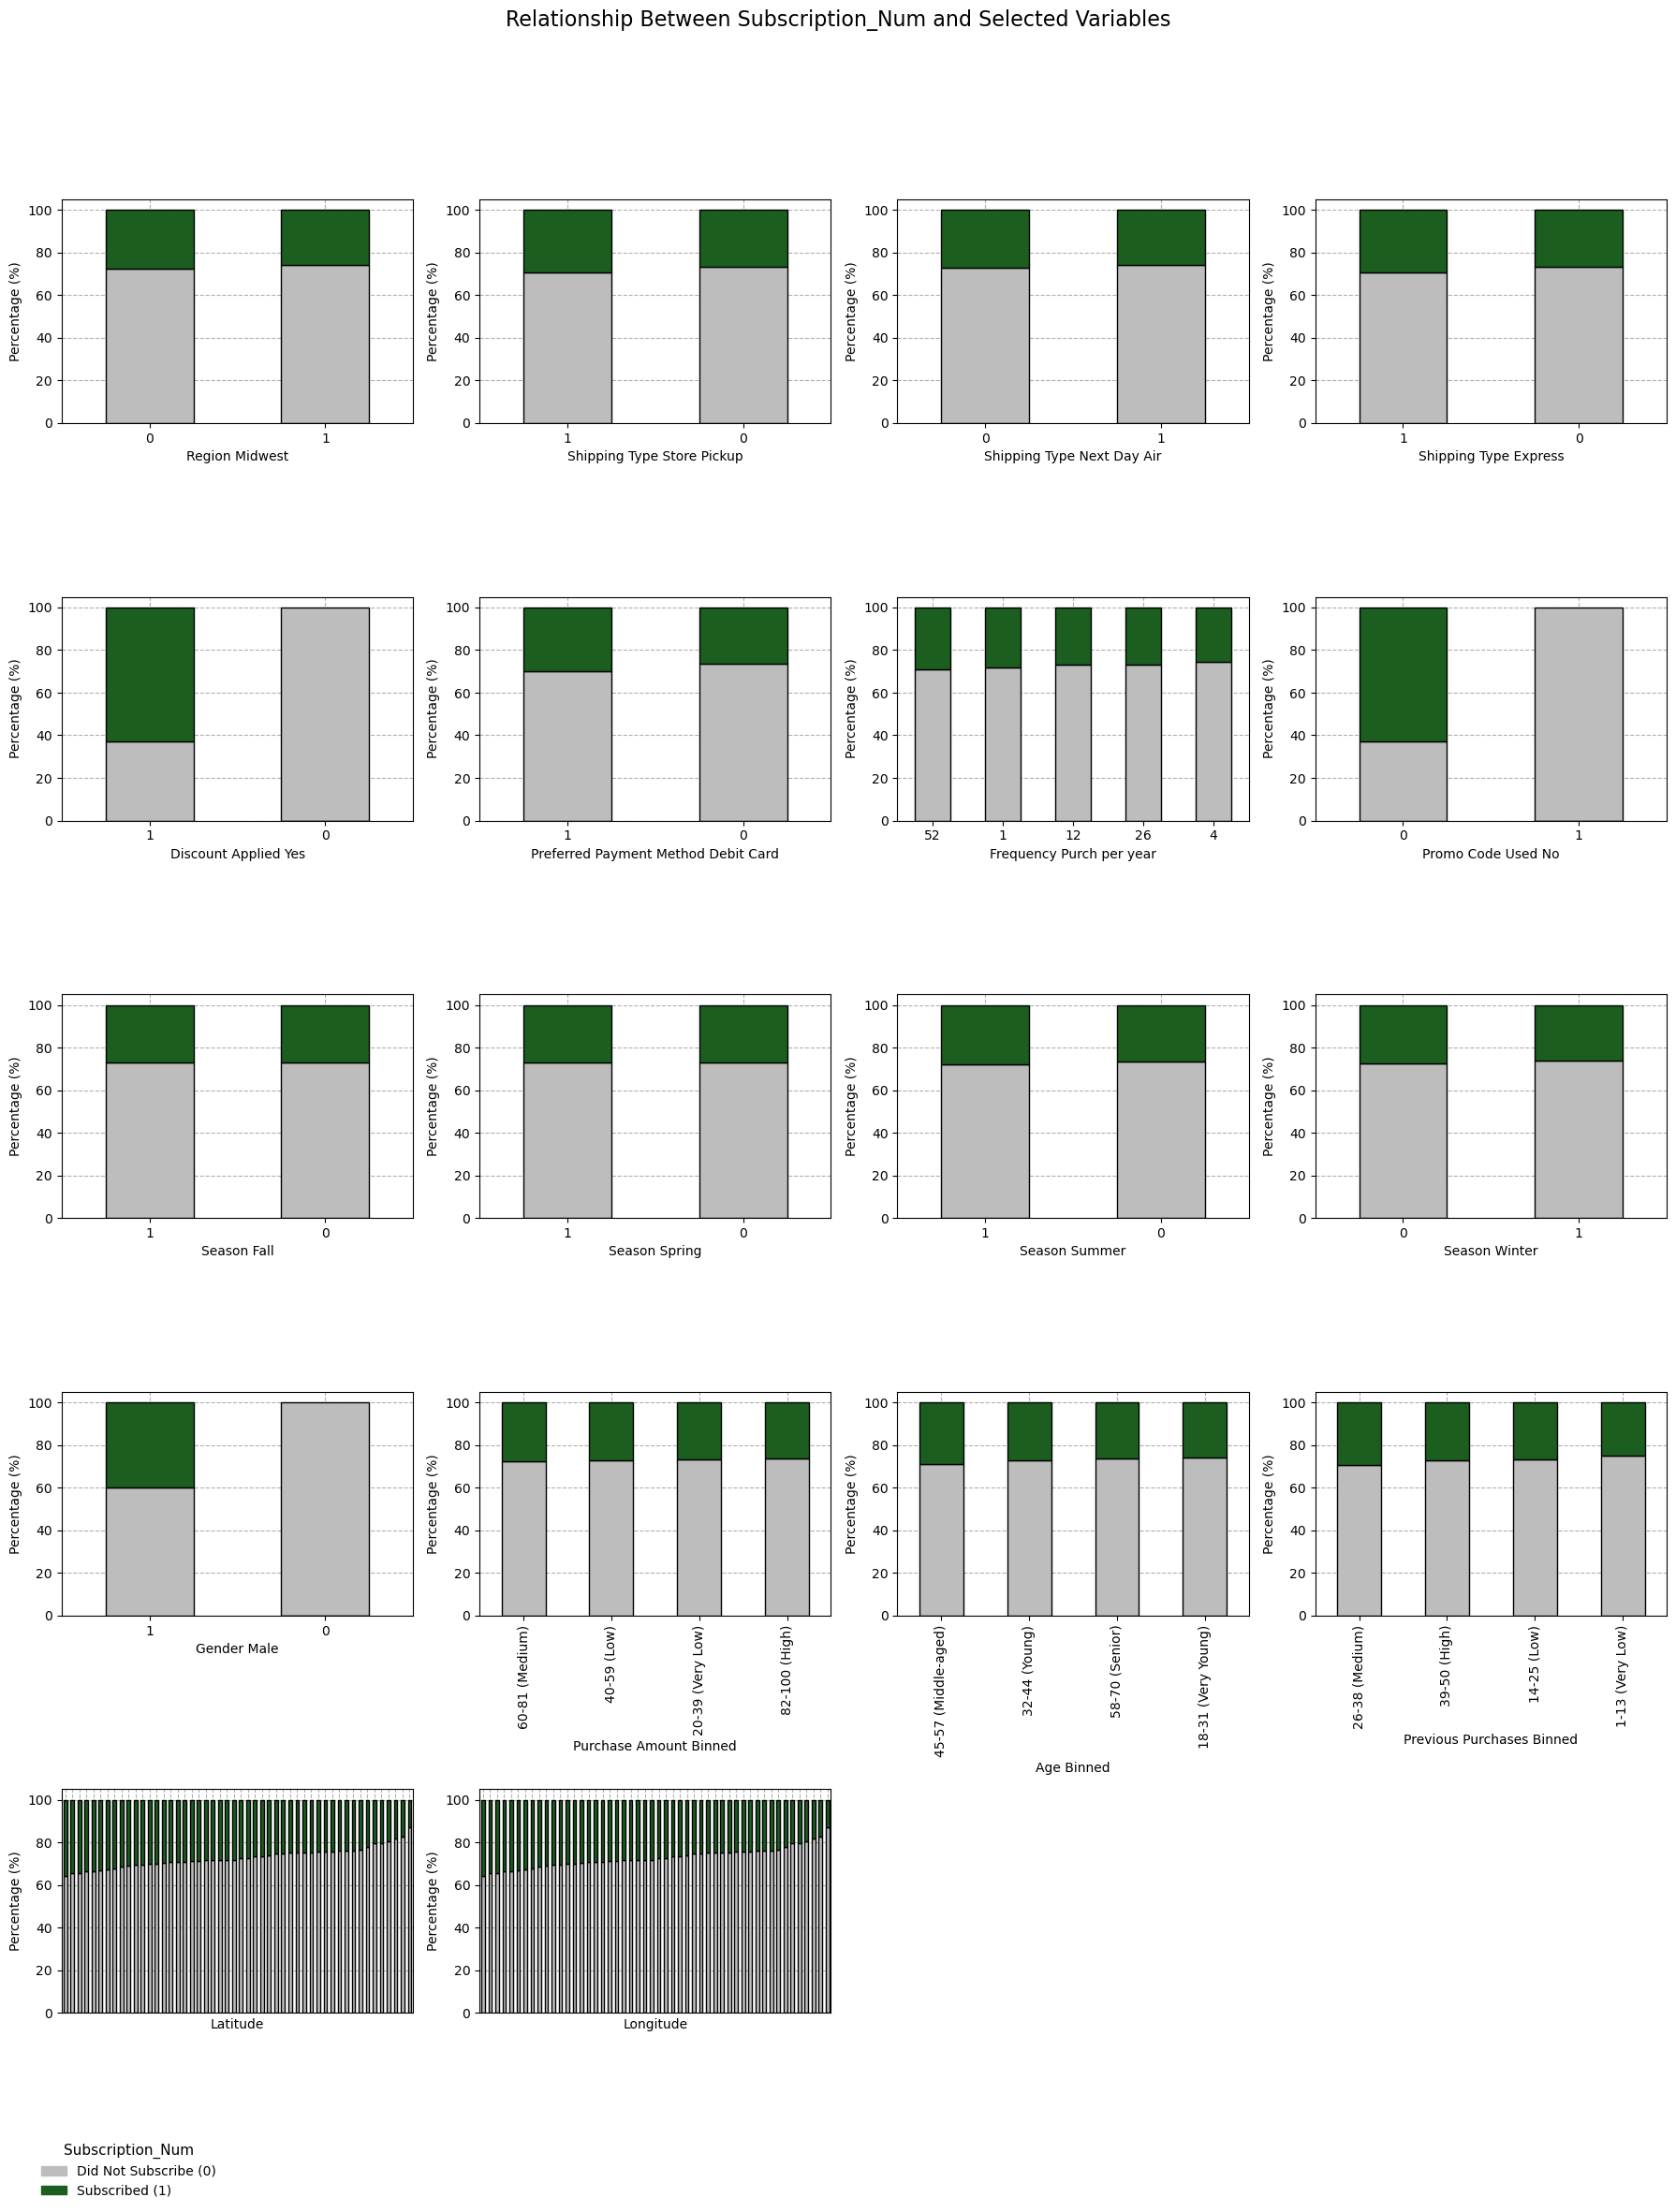


Unique Values in Binned Columns:
            Binned Column                                                            Unique Values
   Purchase_Amount_Binned           [20-39 (Very Low), 40-59 (Low), 60-81 (Medium), 82-100 (High)]
               Age_Binned [18-31 (Very Young), 32-44 (Young), 45-57 (Middle-aged), 58-70 (Senior)]
Previous_Purchases_Binned             [1-13 (Very Low), 14-25 (Low), 26-38 (Medium), 39-50 (High)]




In [75]:
# Creating a copy to avoid altering the original data
data_view = data_copy.copy()

# Custom binning applied directly on data_view
# Purchase_Amount_(USD)
purchase_bins = [20, 39, 59, 81, 100]
purchase_labels = ["20-39 (Very Low)", "40-59 (Low)", "60-81 (Medium)", "82-100 (High)"]
data_view['Purchase_Amount_Binned'] = pd.cut(data_view['Purchase_Amount_(USD)'], bins=purchase_bins, labels=purchase_labels, include_lowest=True)

# Age
age_bins = [18, 31, 44, 57, 70]
age_labels = ["18-31 (Very Young)", "32-44 (Young)", "45-57 (Middle-aged)", "58-70 (Senior)"]
data_view['Age_Binned'] = pd.cut(data_view['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Previous_Purchases
previous_purchases_bins = [1, 13, 25, 38, 50]
previous_purchases_labels = ["1-13 (Very Low)", "14-25 (Low)", "26-38 (Medium)", "39-50 (High)"]
data_view['Previous_Purchases_Binned'] = pd.cut(data_view['Previous_Purchases'], bins=previous_purchases_bins, labels=previous_purchases_labels, include_lowest=True)


# Updating the selected features with binned versions
selected_features = ['Region_Midwest', 'Shipping_Type_Store Pickup', 'Shipping_Type_Next Day Air', 'Shipping_Type_Express',
    'Discount_Applied_Yes', 'Preferred_Payment_Method_Debit Card', 'Frequency_Purch_per_year',
    'Promo_Code_Used_No', 'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Gender_Male', 
    'Purchase_Amount_Binned', 'Age_Binned', 'Previous_Purchases_Binned', 'Latitude', 'Longitude']

# Configuring layout: multiple rows to fit all variables
colors = ['#BDBDBD', '#1B5E20']
num_cols = 4
num_rows = math.ceil(len(selected_features) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()
for i, feature in enumerate(selected_features):
    percent_data = data_view.groupby([feature, 'Subscription_Num']).size().unstack()
    percent_data = percent_data.div(percent_data.sum(axis=1), axis=0) * 100
    percent_data = percent_data.sort_values(by=1, ascending=False)
    percent_data.plot(kind='bar', stacked=True, color=colors, edgecolor='black', ax=axes[i], legend=False)
    axes[i].set_xlabel(feature.replace('_', ' '))
    axes[i].set_ylabel("Percentage (%)")
    if feature in ['Latitude', 'Longitude']:
        axes[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    else:
        axes[i].tick_params(axis='x', rotation=90 if feature.endswith('_Binned') else 0)
    axes[i].set_axisbelow(True)
    axes[i].grid(visible=True, linestyle='--', alpha=1)
for j in range(len(selected_features), len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Relationship Between Subscription_Num and Selected Variables", fontsize=16, y=1.02)
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
fig.legend(handles, 
    ["Did Not Subscribe (0)", "Subscribed (1)"], 
    loc='lower left', 
    title="Subscription_Num", 
    bbox_to_anchor=(0.02, 0.08), 
    fontsize=10, 
    title_fontsize=11, 
    frameon=False)
plt.tight_layout(rect=[0, 0.15, 1, 0.96])
plt.savefig('grafico3.png', dpi=300, bbox_inches='tight')
plt.show()


# Display unique values in the binned columns
binned_columns = ['Purchase_Amount_Binned', 'Age_Binned', 'Previous_Purchases_Binned']
print("\nUnique Values in Binned Columns:")
binned_summary = pd.DataFrame({"Binned Column": binned_columns, "Unique Values": [list(data_view[col].cat.categories) for col in binned_columns]})
print(binned_summary.to_string(index=False))
print("\n")

# Creating table of results per feature
table_results = {}
for feature in selected_features:
    percent_data = data_view.groupby([feature, 'Subscription_Num']).size().unstack()
    percent_data = percent_data.div(percent_data.sum(axis=1), axis=0) * 100
    table_results[feature] = percent_data
#for feature, table in table_results.items():
    #print(f"\nTabela para {feature}:\n")
    #display(table)
final_table = pd.concat(table_results, axis=0)
final_table.index.names = ['Feature', 'Category']
final_table.to_csv("summary_table.csv")


Selected columns for clustering K-Means (S1): Age, Purchase_Amount_(USD), Previous_Purchases, Frequency_Purch_per_year, Gender_Female, Gender_Male, Discount_Applied_No, Discount_Applied_Yes, Payment_Method_Bank Transfer, Payment_Method_Cash, Payment_Method_Credit Card, Payment_Method_Debit Card, Payment_Method_PayPal, Payment_Method_Venmo, Shipping_Type_2-Day Shipping, Shipping_Type_Express, Shipping_Type_Free Shipping, Shipping_Type_Next Day Air, Shipping_Type_Standard, Shipping_Type_Store Pickup, Season_Fall, Season_Spring, Season_Summer, Season_Winter


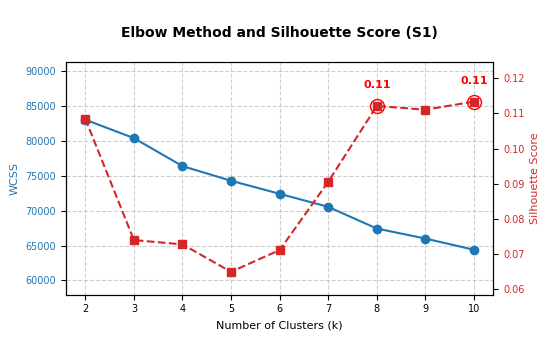

Centroids of Clusters (S1):


,Age,Purchase_Amount_(USD),Previous_Purchases,Frequency_Purch_per_year,Gender_Female,Gender_Male,Discount_Applied_No,Discount_Applied_Yes,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Payment_Method_Debit Card,Payment_Method_PayPal,Payment_Method_Venmo,Shipping_Type_2-Day Shipping,Shipping_Type_Express,Shipping_Type_Free Shipping,Shipping_Type_Next Day Air,Shipping_Type_Standard,Shipping_Type_Store Pickup,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Cluster_S1
0,0.067373,-0.050652,0.087883,0.035530,-0.685994,0.685994,-0.538951,0.538951,0.091039,0.046264,-0.134035,0.010716,-0.006003,-0.003152,-0.437684,-0.445561,-0.457496,-0.446388,2.227847,-0.447214,0.021174,-0.021099,0.021876,-0.021659,1
1,-0.067605,0.029353,0.020367,-0.007445,0.850203,-0.850203,0.868554,-0.868554,0.829204,-0.071135,-0.466078,-0.099806,-0.086538,-0.085194,1.331349,-0.271315,-0.275568,-0.250604,-0.253800,-0.257103,0.021037,0.016046,-0.004551,-0.032738,2
2,0.003681,0.018024,0.034386,-0.012331,-0.685994,0.685994,-0.765138,0.765138,0.013211,0.018364,-0.117330,0.049545,0.041820,-0.001383,0.615763,-0.445561,1.162985,-0.446388,-0.448864,-0.447214,-0.027159,0.004153,0.019866,0.003249,3
3,-0.004992,0.019956,-0.088817,0.009822,1.457738,-1.457738,0.868554,-0.868554,-0.439762,0.182219,-0.466078,0.254998,0.230581,0.250074,-0.437684,0.075586,0.164923,0.034076,0.109615,0.044655,0.038719,-0.013244,-0.014934,-0.010552,4
4,-0.065820,-0.014630,-0.036041,-0.058507,-0.685994,0.685994,-0.521952,0.521952,0.005970,0.079250,-0.119120,0.031474,0.040968,-0.034407,-0.437684,-0.445561,-0.457496,-0.446388,-0.448864,2.236068,-0.103198,0.016337,0.070906,0.016337,5
5,0.040171,0.068703,-0.083423,0.018236,0.521208,-0.521208,0.868554,-0.868554,-0.439762,-0.446388,2.145565,-0.440177,-0.442251,-0.448451,-0.087067,0.036723,0.069831,-0.120740,0.017533,0.081312,0.087477,-0.014098,-0.070290,-0.003468,6
6,0.086263,0.019152,0.067520,0.000772,-0.685994,0.685994,-0.495974,0.495974,0.066186,0.034987,-0.181516,0.012916,-0.036411,0.109267,-0.437684,2.244360,-0.457496,-0.446388,-0.448864,-0.447214,-0.006990,0.062173,-0.023267,-0.032625,7
7,-0.039459,-0.108357,0.024778,0.016583,-0.685994,0.685994,-0.473492,0.473492,-0.036371,0.025581,-0.113153,-0.006503,0.081383,0.052231,-0.437684,-0.445561,-0.457496,2.240205,-0.448864,-0.447214,-0.036409,-0.045056,-0.003787,0.085708,8


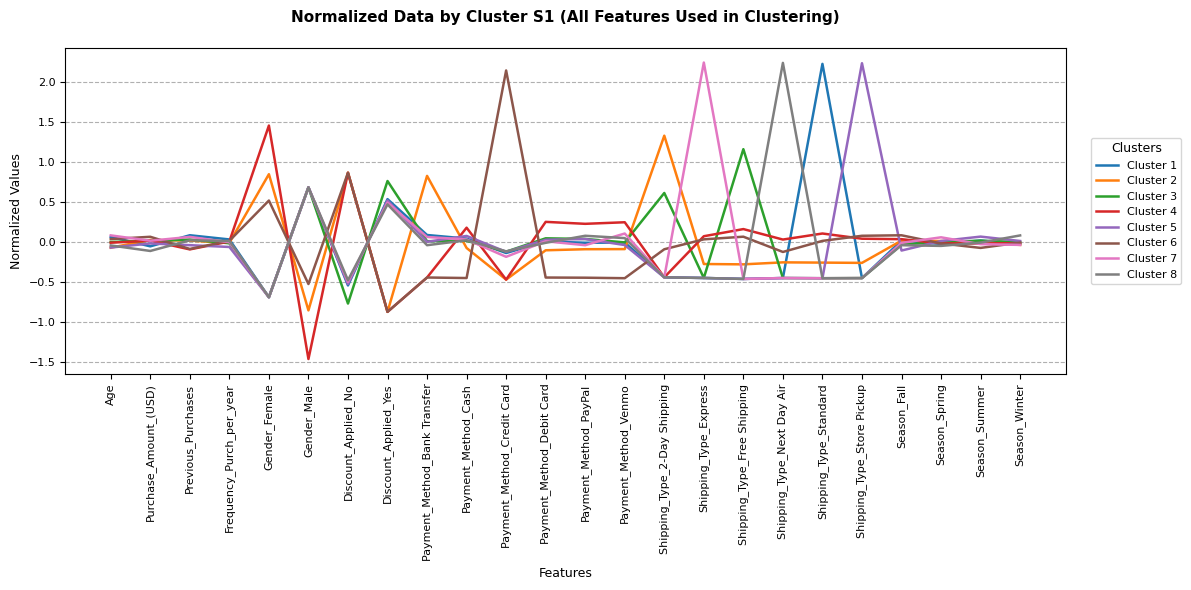

In [76]:
################################## ANSWERING PROBLEM 2 - CLUSTER STRATEGY 1 - S1 #######################################

# Normalizing only the selected columns (including Gender dummies) to analyze how relashionship wit subscription
df = data.copy() 
df = pd.get_dummies(df, columns=['Gender', 'Discount_Applied','Payment_Method', 'Shipping_Type', 'Season'], dtype=np.float64); 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns; columns_to_exclude = ['Latitude', 'Longitude']; 
columns_to_normalize = [col for col in numeric_cols if col not in columns_to_exclude]; scaler = StandardScaler() ; 
normalized_data = scaler.fit_transform(df[columns_to_normalize]); df_normalized = pd.DataFrame(normalized_data, columns=columns_to_normalize); 
df_normalized[columns_to_exclude] = df[columns_to_exclude].reset_index(drop=True)

# Configuring the range of clusters and preparing data
K = range(2, 11); wcss, silhouette_scores = [], []; data_for_clustering = df_normalized.drop(columns=['Latitude', 'Longitude', 'Subscription_Num','Review_Rating']) 
                                                                                                       
print("Selected columns for clustering K-Means (S1): " + ", ".join(data_for_clustering.columns))
for k in K: kmeans = KMeans(n_clusters=k, random_state=42); cluster_labels = kmeans.fit_predict(data_for_clustering); wcss.append(kmeans.inertia_); silhouette_scores.append(silhouette_score(data_for_clustering, cluster_labels))

# Identifying the two best Silhouette Scores, Plotting Silhouette Scores and Elbow Method
best_silhouette_indices = sorted(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i], reverse=True)[:2]; 
best_clusters = [K[i] for i in best_silhouette_indices]
fig, ax1 = plt.subplots(figsize=(5.6, 3.5)); color_wcss = 'tab:blue'; ax1.set_xlabel('Number of Clusters (k)', fontsize=8); 
ax1.set_ylabel('WCSS', color=color_wcss, fontsize=8); ax1.plot(K, wcss, 'o-', color=color_wcss, label='WCSS'); 
ax1.tick_params(axis='y', labelcolor=color_wcss, labelsize=7); ax1.tick_params(axis='x', labelsize=7); 
ax1.set_ylim(min(wcss) * 0.9, max(wcss) * 1.1); ax2 = ax1.twinx(); color_silhouette = 'tab:red'; 
ax2.set_ylabel('Silhouette Score', color=color_silhouette, fontsize=8); 
ax2.plot(K, silhouette_scores, 's--', color=color_silhouette, label='Silhouette Score'); 
ax2.tick_params(axis='y', labelcolor=color_silhouette, labelsize=7); ax2.set_ylim(min(silhouette_scores) * 0.9, max(silhouette_scores) * 1.1)
for i, idx in enumerate(best_silhouette_indices): ax2.plot(K[idx], silhouette_scores[idx], 'o', color='red', markersize=10, markerfacecolor='none'); ax2.text(K[idx], silhouette_scores[idx] + 0.005, f"{silhouette_scores[idx]:.2f}", fontsize=8, color="red", ha='center', weight='bold')
plt.title('\nElbow Method and Silhouette Score (S1)\n', fontsize=10, weight='bold'); ax1.grid(True, linestyle='--', alpha=0.6); 
fig.tight_layout(); plt.show()

# Reapplying K-Means to the normalized dataset and best number of clustering
k_opt = 8 ; kmeans = KMeans(n_clusters=k_opt, random_state=42); data['Cluster_S1'] = kmeans.fit_predict(data_for_clustering) + 1; 
df_normalized['Cluster_S1'] = data['Cluster_S1']

# Extracting centroids for Clusters S1
centroids_s1_df = pd.DataFrame(kmeans.cluster_centers_, columns=data_for_clustering.columns); centroids_s1_df['Cluster_S1'] = range(1, k_opt + 1);
pd.set_option('display.max_columns', None)
print("Centroids of Clusters (S1):"); display(centroids_s1_df)

# Line chart to analyze key characteristics per cluster
selected_features = data_for_clustering.columns  
selected_data = df_normalized.groupby('Cluster_S1')[selected_features].mean()
plt.figure(figsize=(12, 6))  
for cluster in selected_data.index:
    plt.plot(selected_features, selected_data.loc[cluster], label=f'Cluster {cluster}', linewidth=1.8, alpha=1)
plt.title("Normalized Data by Cluster S1 (All Features Used in Clustering)\n", fontsize=11, weight='bold')
plt.xlabel("Features", fontsize=9)
plt.ylabel("Normalized Values", fontsize=9)
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Clusters", fontsize=8, title_fontsize=9, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

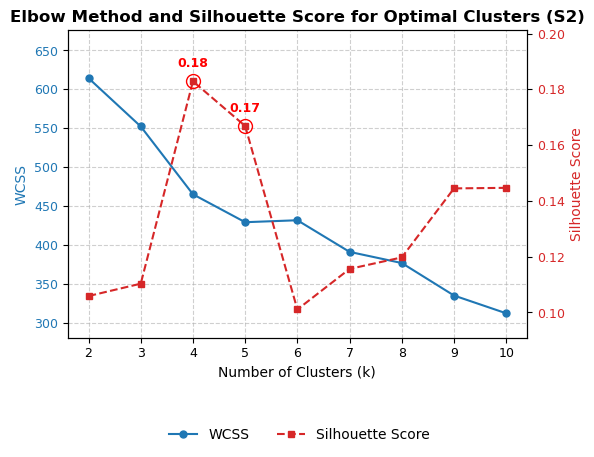


Cluster S2 Legend:
⬤ Cluster 1 | Total Purchased: $75275.00 | Customers: 1271 | Avg: $59.23 | Median: $58.00 | Most Common Category: Clothing | Most Common Item: Hoodie
⬤ Cluster 2 | Total Purchased: $55584.00 | Customers: 937 | Avg: $59.32 | Median: $60.00 | Most Common Category: Clothing | Most Common Item: Sandals
⬤ Cluster 3 | Total Purchased: $62289.00 | Customers: 1018 | Avg: $61.19 | Median: $62.00 | Most Common Category: Clothing | Most Common Item: Backpack
⬤ Cluster 4 | Total Purchased: $39933.00 | Customers: 674 | Avg: $59.25 | Median: $59.00 | Most Common Category: Clothing | Most Common Item: Blouse

Centroids of Clusters (S2):


,Total_Purchase,Avg_Purchase,Avg_Frequency,Num_Transactions,Region_Midwest,Region_Northeast,Region_South,Region_West,Shipping_Type_2-Day Shipping,Shipping_Type_Express,Shipping_Type_Free Shipping,Shipping_Type_Next Day Air,Shipping_Type_Standard,Shipping_Type_Store Pickup,Cluster_S2
0,0.083766,-0.179624,0.329388,0.177972,-0.561951,-0.468521,1.457738,-0.592749,-0.093688,0.247934,0.209579,0.037713,-0.376414,-0.071576,1
1,-0.057611,-0.173349,-0.204675,0.010317,1.779513,-0.468521,-0.685994,-0.592749,-0.047856,0.231583,-0.248715,-0.720015,0.231864,0.414409,2
2,0.252540,0.489334,-0.044459,0.038094,-0.561951,-0.468521,-0.685994,1.687055,0.017943,-0.407285,0.170564,0.343302,0.052569,-0.100068,3
3,-0.436883,-0.156353,-0.248460,-0.385175,-0.561951,2.134375,-0.685994,-0.592749,0.204446,-0.161249,-0.287334,0.397094,0.284097,-0.280756,4


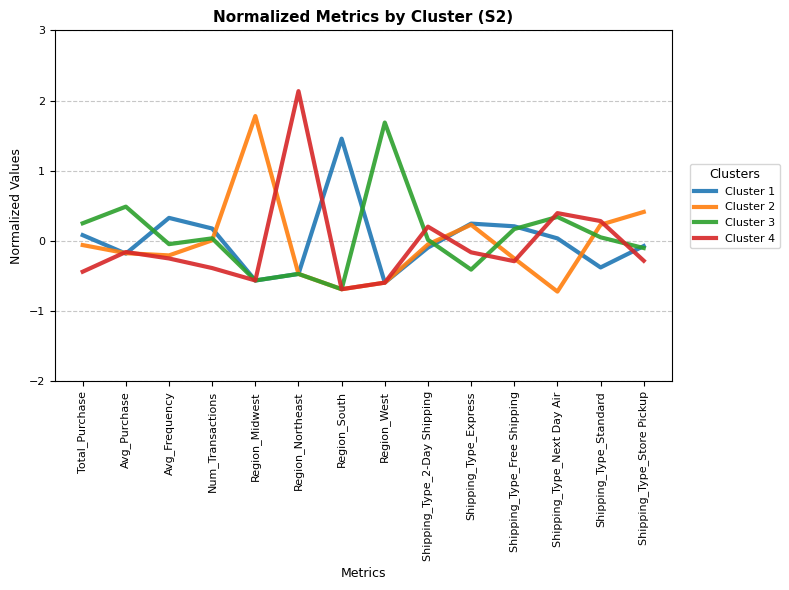


Clusters S2 and States:
Cluster 1: Alabama, Arkansas, Delaware, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, West Virginia
Cluster 2: Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin
Cluster 3: Alaska, Arizona, California, Colorado, Hawaii, Idaho, Montana, Nevada, New Mexico, Oregon, Utah, Washington, Wyoming
Cluster 4: Connecticut, Maine, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, Vermont


[None, None, None, None]

In [77]:
################################### PROBLEM 2 - CLUSTER S2 PER REGION AND OTHER VARIABLES #################################

# Aggregating metrics by state
state_data = data.groupby(['Latitude', 'Longitude']).agg({'Purchase_Amount_(USD)': ['sum', 'mean'], 'Frequency_Purch_per_year': 'mean'}).reset_index()
state_data.columns = ['Latitude', 'Longitude', 'Total_Purchase', 'Avg_Purchase', 'Avg_Frequency']
state_data['Num_Transactions'] = data.groupby(['Latitude', 'Longitude']).size().values

# Adding Region, Shipping_Type, Preferred_Payment_Method, and Season
data_dummies = pd.get_dummies(data[['Region', 'Shipping_Type']], dtype=float)


# Aggregate dummy variables by state
categorical_agg = data[['Latitude', 'Longitude']].join(data_dummies).groupby(['Latitude', 'Longitude']).mean().reset_index()


# Merge aggregated categorical variables with state_data
state_data = state_data.merge(categorical_agg, on=['Latitude', 'Longitude'])


# Normalizing metrics and preparing for clustering
X = state_data.drop(columns=['Latitude', 'Longitude']) ; 
X_normalized = StandardScaler().fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns, index=state_data.index)


# Finding the optimal number of clusters using both WCSS and Silhouette Score
K = range(2, 11)
wcss = []
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_normalized)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_normalized, cluster_labels))


# Identifying the two best Silhouette Scores
best_silhouette_indices = sorted(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i], reverse=True)[:2]
best_clusters = [K[i] for i in best_silhouette_indices]


# Plotting WCSS (Elbow Method) and Silhouette Score on the secondary axis
fig, ax1 = plt.subplots(figsize=(6, 4))
color_wcss = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=10)
ax1.set_ylabel('WCSS', color=color_wcss, fontsize=10)
ax1.plot(K, wcss, 'o-', color=color_wcss, label='WCSS', markersize=5, linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color_wcss, labelsize=9)
ax1.tick_params(axis='x', labelsize=9)
ax1.set_ylim(min(wcss) * 0.9, max(wcss) * 1.1)  # Aumentando os limites do eixo Y do WCSS
ax2 = ax1.twinx()
color_silhouette = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color_silhouette, fontsize=10)
ax2.plot(K, silhouette_scores, 's--', color=color_silhouette, label='Silhouette Score', markersize=5, linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color_silhouette, labelsize=9)
ax2.set_ylim(min(silhouette_scores) * 0.9, max(silhouette_scores) * 1.1)  # Aumentando os limites do eixo Y do Silhouette Score
for i, idx in enumerate(best_silhouette_indices):
    ax2.plot(K[idx], silhouette_scores[idx], 'o', color='red', markersize=10, markerfacecolor='none')
    ax2.text(K[idx], silhouette_scores[idx] + 0.005, f"{silhouette_scores[idx]:.2f}", fontsize=9, color="red", ha='center', weight='bold')
plt.title('Elbow Method and Silhouette Score for Optimal Clusters (S2)', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
fig.legend(['WCSS', 'Silhouette Score'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()


# Setting the number of clusters manually
manual_k = 4
if manual_k not in K:
    raise ValueError(f"Invalid choice. Please choose a value from the range: {list(K)}")


# Applying K-Means with the manually chosen number of clusters
kmeans = KMeans(n_clusters=manual_k, random_state=42)
state_data['Cluster_S2'] = kmeans.fit_predict(X_normalized) + 1

# Updating the original dataset with clusters
data['Latitude'], data['Longitude'] = data['Latitude'].astype('float64').round(6), data['Longitude'].astype('float64').round(6)
state_data['Latitude'], state_data['Longitude'] = state_data['Latitude'].astype('float64').round(6), state_data['Longitude'].astype('float64').round(6)
data = data.merge(state_data[['Latitude', 'Longitude', 'Cluster_S2']], on=['Latitude', 'Longitude'], how='left')

# Creating a dynamic map with clusters, with statistics and legend
state_data['Bubble_Size'] = (state_data['Total_Purchase'] / state_data['Total_Purchase'].max()) * 10
n_clusters = state_data['Cluster_S2'].nunique()
cmap = cm.get_cmap('tab10', n_clusters)
colors = [mcolors.to_hex(cmap(i)) for i in range(n_clusters)]
mymap = folium.Map(location=[state_data['Latitude'].mean(), state_data['Longitude'].mean()], zoom_start=5)
for _, row in state_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Bubble_Size'],
        color=colors[int(row['Cluster_S2']) - 1],
        fill_color=colors[int(row['Cluster_S2']) - 1],
        fill=True,
        fill_opacity=1,
        popup=f"State: {row['Latitude']}, {row['Longitude']}, Cluster: {row['Cluster_S2']}, "
              f"Total Purchase: {row['Total_Purchase']:.2f}, Avg Purchase: {row['Avg_Purchase']:.2f}, "
              f"Avg Frequency: {row['Avg_Frequency']:.2f}, Num Transactions: {row['Num_Transactions']}"    ).add_to(mymap)
display(mymap)
cluster_stats = data.groupby('Cluster_S2').agg( Total_Purchase_Amount=('Purchase_Amount_(USD)', 'sum'), Customer_Count=('Purchase_Amount_(USD)', 'count'), Avg_Purchase_Amount=('Purchase_Amount_(USD)', 'mean'), Median_Purchase_Amount=('Purchase_Amount_(USD)', 'median'), Most_Common_Category=('Category', lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'), Most_Common_Item=('Item_Purchased', lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A')).reset_index(); 
print("\nCluster S2 Legend:")
for cluster, color in zip(range(1, n_clusters + 1), colors):
    stats = cluster_stats[cluster_stats['Cluster_S2'] == cluster].iloc[0]; print(f"\033[38;2;{int(mcolors.hex2color(color)[0] * 255)};{int(mcolors.hex2color(color)[1] * 255)};"f"{int(mcolors.hex2color(color)[2] * 255)}m⬤\033[0m Cluster {cluster} | "f"Total Purchased: ${stats['Total_Purchase_Amount']:.2f} | Customers: {stats['Customer_Count']} | "f"Avg: ${stats['Avg_Purchase_Amount']:.2f} | Median: ${stats['Median_Purchase_Amount']:.2f} | "f"Most Common Category: {stats['Most_Common_Category']} | Most Common Item: {stats['Most_Common_Item']}")

# Cluster Analysis
centroids_s2_df = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids_s2_df['Cluster_S2'] = range(1, manual_k + 1)
print("\nCentroids of Clusters (S2):")
display(centroids_s2_df)


# Line Chart for Clusters
normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
normalized_df['Cluster_S2'] = state_data['Cluster_S2']
cluster_means = normalized_df.groupby('Cluster_S2').mean()
plt.figure(figsize=(8, 6))
for cluster in cluster_means.index:
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], label=f'Cluster {cluster}', linewidth=3, alpha=0.9)
plt.title("Normalized Metrics by Cluster (S2)", fontsize=11, weight='bold')
plt.xlabel("Metrics", fontsize=9)
plt.ylabel("Normalized Values", fontsize=9)
plt.xticks(rotation=90, ha='center', fontsize=8)  
plt.yticks(fontsize=8)
plt.ylim(-2, 3)
plt.legend(title="Clusters", fontsize=8, title_fontsize=9, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Grouping states by cluster and sort alphabetically
cluster_states = data.groupby('Cluster_S2')['Location'].apply(lambda x: sorted(x.unique())); cluster_table = pd.DataFrame({'Cluster': cluster_states.index, 'States': cluster_states.values}).sort_values(by='Cluster')
# Displaying formatted results
print("\nClusters S2 and States:"); [print(f"Cluster {row['Cluster']}: {', '.join(row['States'])}") for _, row in cluster_table.iterrows()]



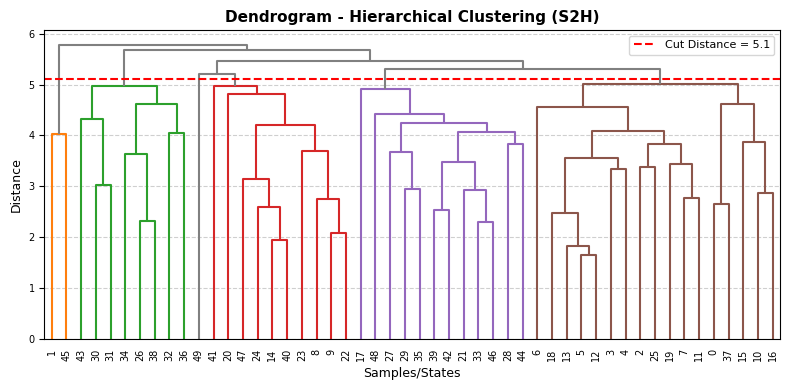

Silhouette Score for hierarchical clustering: 0.15



Cluster Legend for S2H:
⬤ Cluster 1 | Total Purchased: $8186.00 | Customers: 145 | Avg: $56.46 | Median: $56.00 | Most Common Category: Clothing | Most Common Item: Coat
⬤ Cluster 2 | Total Purchased: $35545.00 | Customers: 597 | Avg: $59.54 | Median: $59.00 | Most Common Category: Clothing | Most Common Item: Dress
⬤ Cluster 3 | Total Purchased: $49361.00 | Customers: 810 | Avg: $60.94 | Median: $62.00 | Most Common Category: Clothing | Most Common Item: Backpack
⬤ Cluster 4 | Total Purchased: $4867.00 | Customers: 72 | Avg: $67.60 | Median: $68.50 | Most Common Category: Clothing | Most Common Item: Backpack
⬤ Cluster 5 | Total Purchased: $55584.00 | Customers: 937 | Avg: $59.32 | Median: $60.00 | Most Common Category: Clothing | Most Common Item: Sandals
⬤ Cluster 6 | Total Purchased: $79538.00 | Customers: 1339 | Avg: $59.40 | Median: $59.00 | Most Common Category: Clothing | Most Common Item: Hoodie

Centroids of Clusters (S2H) - Normalized:


,Total_Purchase,Avg_Purchase,Avg_Frequency,Num_Transactions,Region_Midwest,Region_Northeast,Region_South,Region_West,Shipping_Type_2-Day Shipping,Shipping_Type_Express,Shipping_Type_Free Shipping,Shipping_Type_Next Day Air,Shipping_Type_Standard,Shipping_Type_Store Pickup
Cluster_S2H,,,,,,,,,,,,,,
1,-1.105960,-1.105398,-0.647021,-0.680935,-0.561951,0.832927,0.385872,-0.592749,-0.732131,1.149163,2.043026,-1.581114,0.343971,-1.220564
2,-0.424970,-0.060955,-0.200788,-0.417847,-0.561951,2.134375,-0.685994,-0.592749,0.370716,-0.347872,-0.593735,0.668985,0.317361,-0.218291
3,0.533861,0.418702,-0.457622,0.371419,-0.561951,-0.468521,-0.685994,1.687055,0.229894,-0.687107,0.292376,0.585414,-0.049077,-0.239334
4,0.399462,2.558307,0.956470,-0.742838,-0.561951,-0.468521,-0.685994,1.687055,0.535250,0.345810,0.543650,-1.571389,1.981036,-1.470665
5,-0.057611,-0.173349,-0.204675,0.010317,1.779513,-0.468521,-0.685994,-0.592749,-0.047856,0.231583,-0.248715,-0.720015,0.231864,0.414409
6,0.033232,-0.115688,0.528012,0.094675,-0.561951,-0.468521,1.205534,-0.324537,-0.221258,0.248877,0.010647,0.127516,-0.441145,0.181091


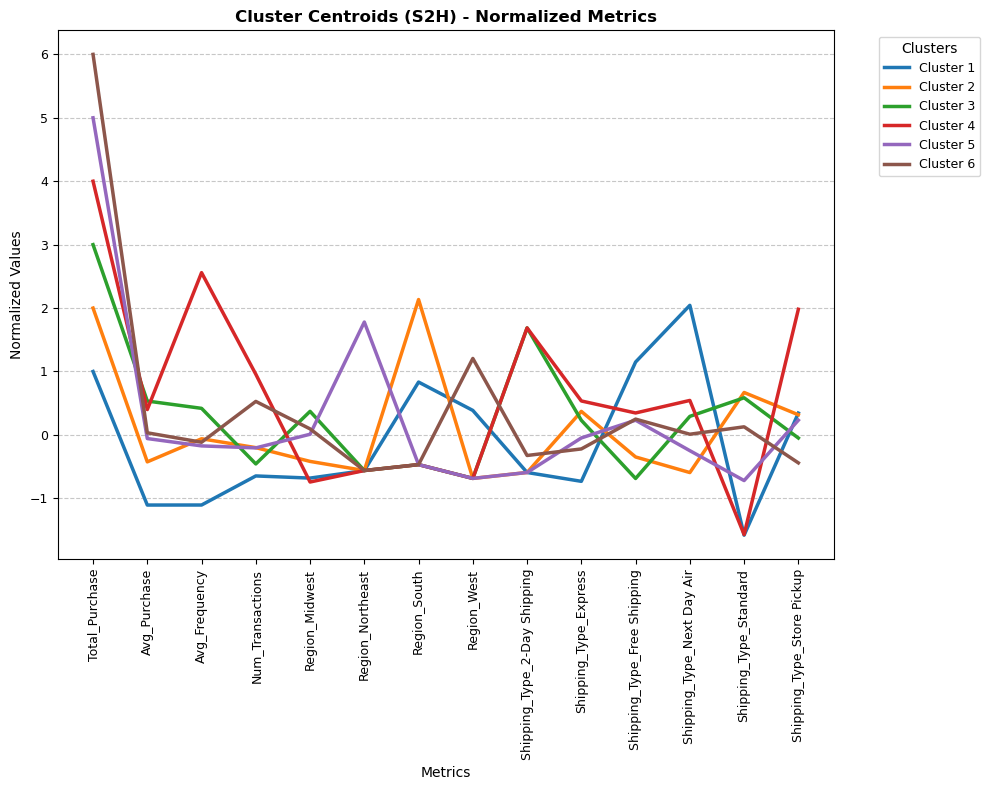


Clusters S2H and States:
Cluster 1: Florida, Maine
Cluster 2: Connecticut, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, Vermont
Cluster 3: Arizona, California, Colorado, Idaho, Montana, Nevada, New Mexico, Oregon, Utah, Washington
Cluster 4: Alaska
Cluster 5: Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin
Cluster 6: Alabama, Arkansas, Delaware, Georgia, Hawaii, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, West Virginia, Wyoming


[None, None, None, None, None, None]

In [78]:
################# PROBLEM 2 - CLUSTER S2 PER REGION AND OTHER VARIABLES | VIEW HIERARQUICAL ( S2H) ####################

# Applying hierarchical clustering (average linkage and Euclidean distance)
X = X_normalized 
linkage_method = 'average'; Z = linkage(X, method=linkage_method, metric='euclidean')

# Defining the cutoff point and plotting the dendrogram
cut_distance = 5.1 ; cluster_labels_hierarchical = fcluster(Z, t=cut_distance, criterion='distance'); 
plt.figure(figsize=(8, 4)); plt.title("Dendrogram - Hierarchical Clustering (S2H)", fontsize=11, weight='bold'); 
dendrogram(Z, color_threshold=cut_distance, leaf_rotation=90., leaf_font_size=8, above_threshold_color='gray'); 
plt.axhline(y=cut_distance, color='red', linestyle='--', linewidth=1.5, label=f"Cut Distance = {cut_distance}"); 
plt.xlabel("Samples/States", fontsize=9); plt.ylabel("Distance", fontsize=9); plt.xticks(fontsize=7); plt.yticks(fontsize=7); 
plt.legend(fontsize=8, loc='upper right'); plt.grid(axis='y', linestyle='--', alpha=0.6); plt.tight_layout(); plt.show(); 
silhouette_avg = silhouette_score(X_normalized, cluster_labels_hierarchical); print(f"Silhouette Score for hierarchical clustering: {silhouette_avg:.2f}")

# Adding cluster labels to the DataFrame
state_data['Cluster_S2H'] = cluster_labels_hierarchical.astype('int64') ; data[['Latitude', 'Longitude']] = data[['Latitude', 'Longitude']].astype('float64').round(6); state_data[['Latitude', 'Longitude']] = state_data[['Latitude', 'Longitude']].astype('float64').round(6) ; data = data.merge(state_data[['Latitude', 'Longitude', 'Cluster_S2H']], on=['Latitude', 'Longitude'], how='left')

# Visualize clusters on the map
n_clusters_hierarchical = state_data['Cluster_S2H'].nunique(); cmap = cm.get_cmap('tab10', n_clusters_hierarchical); colors_hierarchical = [mcolors.to_hex(cmap(i)) for i in range(n_clusters_hierarchical)]; mymap_hierarchical = folium.Map(location=[state_data['Latitude'].mean(), state_data['Longitude'].mean()], zoom_start=5)
for _, row in state_data.iterrows():
    cluster_color = colors_hierarchical[int(row['Cluster_S2H']) - 1]; folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=row['Bubble_Size'], color=cluster_color, fill_color=cluster_color, fill=True, fill_opacity=1, popup=f"State: {row['Latitude']}, {row['Longitude']}, Cluster (S2H): {row['Cluster_S2H']}, "f"Total Purchase: {row['Total_Purchase']:.2f}, Avg Purchase: {row['Avg_Purchase']:.2f}, "f"Avg Frequency: {row['Avg_Frequency']:.2f}, Num Transactions: {row['Num_Transactions']}").add_to(mymap_hierarchical)
display(mymap_hierarchical)

# Calculate cluster statistics for S2H and Displaying
cluster_stats_s2h = data.groupby('Cluster_S2H').agg(Total_Purchase_Amount=('Purchase_Amount_(USD)', 'sum'), Customer_Count=('Purchase_Amount_(USD)', 'count'), Avg_Purchase_Amount=('Purchase_Amount_(USD)', 'mean'), Median_Purchase_Amount=('Purchase_Amount_(USD)', 'median'), Most_Common_Category=('Category', lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'), Most_Common_Item=('Item_Purchased', lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A')).reset_index()
print("\nCluster Legend for S2H:")
for cluster, color in zip(range(1, n_clusters_hierarchical + 1), colors_hierarchical):
    stats = cluster_stats_s2h[cluster_stats_s2h['Cluster_S2H'] == cluster].iloc[0]; r, g, b = [int(mcolors.hex2color(color)[i] * 255) for i in range(3)] ; print(f"\033[38;2;{r};{g};{b}m⬤\033[0m Cluster {cluster} | "f"Total Purchased: ${stats['Total_Purchase_Amount']:.2f} | Customers: {stats['Customer_Count']} | "f"Avg: ${stats['Avg_Purchase_Amount']:.2f} | Median: ${stats['Median_Purchase_Amount']:.2f} | "f"Most Common Category: {stats['Most_Common_Category']} | Most Common Item: {stats['Most_Common_Item']}")

# Variable used
variables_used = ['Total_Purchase', 'Avg_Purchase', 'Avg_Frequency', 'Num_Transactions',
    'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West',
    'Shipping_Type_2-Day Shipping', 'Shipping_Type_Express', 'Shipping_Type_Free Shipping',
    'Shipping_Type_Next Day Air', 'Shipping_Type_Standard', 'Shipping_Type_Store Pickup']


# Applying hierarchical clustering with the same variables used in S2
X_s2h = state_data[variables_used]
X_s2h_normalized = StandardScaler().fit_transform(X_s2h)

# Recomputing the linkage and defining S2H clusters
Z = linkage(X_s2h_normalized, method='average', metric='euclidean')
cut_distance = 5.1
hierarchical_cluster_labels = fcluster(Z, t=cut_distance, criterion='distance')

# Adding S2H cluster labels to the state_data DataFrame
state_data['Cluster_S2H'] = hierarchical_cluster_labels.astype('int64')

# Calculating centroids in the normalized space
X_s2h_normalized_df = pd.DataFrame(X_s2h_normalized, columns=variables_used)
X_s2h_normalized_df['Cluster_S2H'] = hierarchical_cluster_labels
centroids_s2h_normalized = X_s2h_normalized_df.groupby('Cluster_S2H').mean()

# Displaying the normalized centroids
print("\nCentroids of Clusters (S2H) - Normalized:")
display(centroids_s2h_normalized)

# Resetting the index for the normalized centroids DataFrame for plotting
centroids_s2h_normalized.reset_index(inplace=True)


# Ensuring only metrics (exclude the 'Cluster_S2H' column) are used for the x-axis
metrics = centroids_s2h_normalized.drop(columns=['Cluster_S2H']).columns  
plt.figure(figsize=(10, 8))
for cluster in centroids_s2h_normalized['Cluster_S2H']:
    plt.plot( metrics, centroids_s2h_normalized[centroids_s2h_normalized['Cluster_S2H'] == cluster].iloc[0, :-1], label=f'Cluster {int(cluster)}', linewidth=2.5, alpha=1)
plt.title("Cluster Centroids (S2H) - Normalized Metrics", fontsize=12, weight='bold')
plt.xlabel("Metrics", fontsize=10)
plt.ylabel("Normalized Values", fontsize=10)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title="Clusters", fontsize=9, title_fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafico6.png', dpi=300, bbox_inches='tight')
plt.show()

# Grouping states by cluster and sort alphabetically
cluster_states = data.groupby('Cluster_S2H')['Location'].apply(lambda x: sorted(x.unique())); cluster_table = pd.DataFrame({'Cluster': cluster_states.index, 'States': cluster_states.values}).sort_values(by='Cluster')
# Displaying formatted results
print("\nClusters S2H and States:"); [print(f"Cluster {row['Cluster']}: {', '.join(row['States'])}") for _, row in cluster_table.iterrows()]




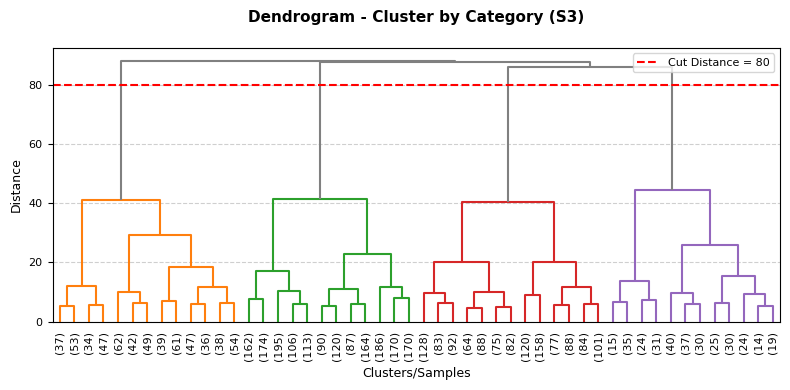

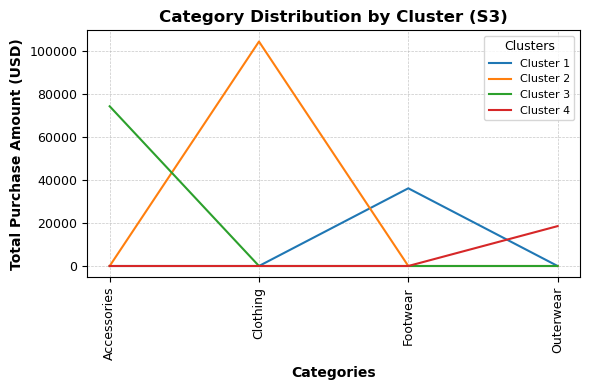

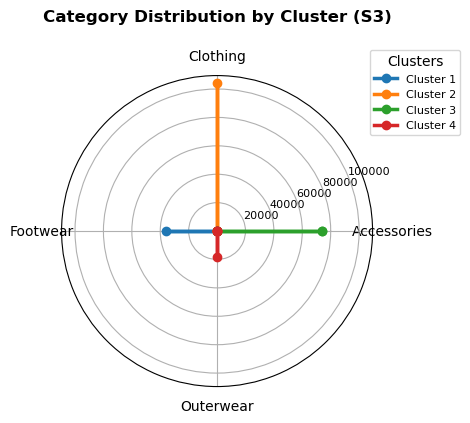


Centroids of Clusters (S3) by Category:


,Accessories,Clothing,Footwear,Outerwear
Cluster_S3,,,,
1,0.00000,0.000000,60.255426,0.00000
2,0.00000,60.025331,0.000000,0.00000
3,59.83871,0.000000,0.000000,0.00000
4,0.00000,0.000000,0.000000,57.17284


In [79]:
##################################### PROBLEM 3 CLUSERING S3 - PER CATEGORY ############################################

# Converting the 'Category' column into dummy variables
data_dummies = pd.get_dummies(data, columns=['Category'], prefix='', prefix_sep='')


# Aggregating data by customer (index) and categories, summing the Purchase Amount values
aggregated_data = data_dummies.groupby(data.index).apply(
    lambda group: group[
        [col for col in data_dummies.columns if col in data['Category'].unique()]
    ].multiply(group['Purchase_Amount_(USD)'], axis=0).sum())


# Applying hierarchical clustering without normalization
linkage_method = 'average'
Z = linkage(aggregated_data, method=linkage_method, metric='euclidean')
cut_distance = 80  
plt.figure(figsize=(8, 4))
plt.title("Dendrogram - Cluster by Category (S3)\n", fontsize=11, weight='bold')
dendrogram(Z, labels=None, leaf_rotation=90., leaf_font_size=8, color_threshold=0.7 * max(Z[:, 2]), truncate_mode='lastp', p=50, above_threshold_color='gray')
plt.axhline(y=cut_distance, color='red', linestyle='--', linewidth=1.5, label=f"Cut Distance = {cut_distance}")
plt.xlabel("Clusters/Samples", fontsize=9)
plt.ylabel("Distance", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Assigning clusters and add to the DataFrame
cluster_labels = fcluster(Z, t=cut_distance, criterion='distance')
aggregated_data['Cluster_S3'] = cluster_labels
aggregated_data = aggregated_data.reindex(data.index)
data['Cluster_S3'] = aggregated_data['Cluster_S3']


# Grouping data by cluster and calculate the sum for each category
clustered_heatmap_data = aggregated_data.groupby('Cluster_S3').sum()


# Creating a line chart as needed
plt.figure(figsize=(6, 4))
for cluster in clustered_heatmap_data.index:
    plt.plot(clustered_heatmap_data.columns, clustered_heatmap_data.loc[cluster],
        label=f"Cluster {cluster}", linewidth=1.5, markersize=5)
plt.title("Category Distribution by Cluster (S3)", fontsize=12, weight='bold')
plt.xlabel("Categories", fontsize=10, weight='bold')
plt.ylabel("Total Purchase Amount (USD)", fontsize=10, weight='bold')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(title="Clusters", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()


# Creating a radar chart to visualize category distribution by cluster
categories = clustered_heatmap_data.columns.tolist()
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  
plt.figure(figsize=(5, 5))  
for cluster in clustered_heatmap_data.index:
    values = clustered_heatmap_data.loc[cluster].values.flatten().tolist()
    values += values[:1] 
    plt.polar(angles, values, label=f"Cluster {cluster}", linewidth=2.5,marker='o', alpha=1)
plt.xticks(angles[:-1], categories, fontsize=10, color='black')
ax = plt.gca()  
ax.yaxis.set_tick_params(labelsize=8, labelcolor='black') 
plt.title("Category Distribution by Cluster (S3)", fontsize=12, weight='bold', pad=20)
plt.legend(title="Clusters", loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8, title_fontsize=10)
plt.tight_layout()
plt.show()


# Calculate centroids for each cluster
centroids_s3 = aggregated_data.groupby('Cluster_S3').mean()
centroids_s3 = centroids_s3.drop(columns=['Cluster_S3'], errors='ignore')
print("\nCentroids of Clusters (S3) by Category:")
display(centroids_s3)




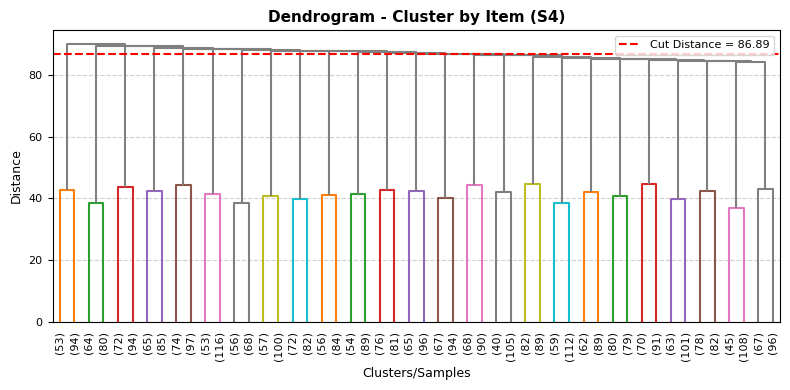

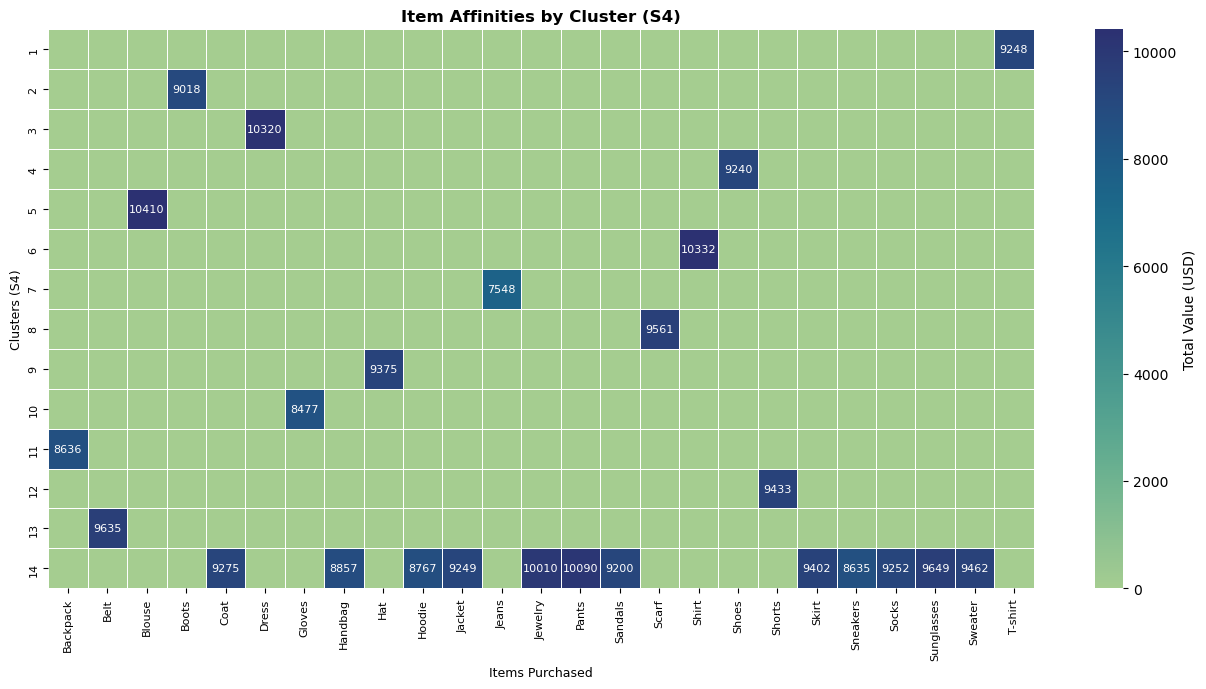


Centroids of Clusters (S4):


,Backpack,Belt,Blouse,Boots,Coat,Dress,Gloves,Handbag,Hat,Hoodie,Jacket,Jeans,Jewelry,Pants,Sandals,Scarf,Shirt,Shoes,Shorts,Skirt,Sneakers,Socks,Sunglasses,Sweater,T-shirt
Cluster_S4,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.911565
2,0.000000,0.00000,0.000000,62.625,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000,0.000000,62.168675,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,60.877193,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.136095,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,60.870968,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.898089,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.00000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,60.876623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [80]:
####################################### PROBLEM 3 CLUSTERING S4 - PER ITEM ############################################

# Converting the 'Item_Purchased' column into dummy variables
data_dummies = pd.get_dummies(data, columns=['Item_Purchased'], prefix='', prefix_sep='')


# Aggregating data by customer (index) and items, summing the Purchase Amount values
aggregated_data_s4 = data_dummies.groupby(data.index).apply(
    lambda group: group[
        [col for col in data_dummies.columns if col in data['Item_Purchased'].unique()]
    ].multiply(group['Purchase_Amount_(USD)'], axis=0).sum())


# Applying hierarchical clustering without normalization
linkage_method = 'average'
Z_s4 = linkage(aggregated_data_s4, method=linkage_method, metric='euclidean')
cut_distance_s4 = 86.89  
plt.figure(figsize=(8, 4))
plt.title("Dendrogram - Cluster by Item (S4)", fontsize=11, weight='bold')
dendrogram(Z_s4, labels=None, leaf_rotation=90., leaf_font_size=8,color_threshold=0.7 * max(Z_s4[:, 2]), truncate_mode='lastp', p=50, above_threshold_color='gray')
plt.axhline(y=cut_distance_s4, color='red', linestyle='--', linewidth=1.5, label=f"Cut Distance = {cut_distance_s4}")
plt.xlabel("Clusters/Samples", fontsize=9)
plt.ylabel("Distance", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Assigning clusters and add to the DataFrame
cluster_labels_s4 = fcluster(Z_s4, t=cut_distance_s4, criterion='distance')
aggregated_data_s4['Cluster_S4'] = cluster_labels_s4
aggregated_data_s4 = aggregated_data_s4.reindex(data.index)
data['Cluster_S4'] = aggregated_data_s4['Cluster_S4']


# Groupping data by cluster and create heatmap
clustered_heatmap_data_s4 = aggregated_data_s4.groupby('Cluster_S4').sum()
formatted_data = clustered_heatmap_data_s4.applymap(lambda x: "" if x == 0 else f"{x:.0f}")
plt.figure(figsize=(13, 7))
sns.heatmap(clustered_heatmap_data_s4, cmap='crest', linewidths=0.5, linecolor='white',
    annot=formatted_data, fmt="", annot_kws={"fontsize": 8}, cbar_kws={'label': 'Total Value (USD)'})
plt.title("Item Affinities by Cluster (S4)", fontsize=12, weight='bold')
plt.xlabel("Items Purchased", fontsize=9)
plt.ylabel("Clusters (S4)", fontsize=9)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('grafico7.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate centroids for each cluster (S4)
centroids_s4 = aggregated_data_s4.groupby('Cluster_S4').mean()
print("\nCentroids of Clusters (S4):")
display(centroids_s4)


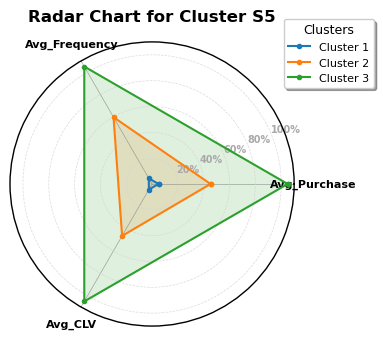

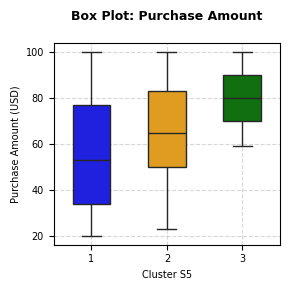

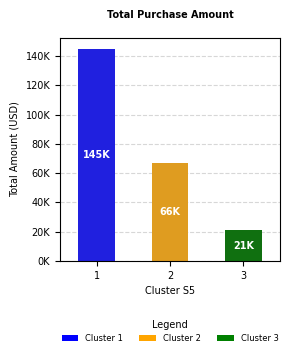


Centroids of Clusters (S5):


,Avg_Purchase,Avg_Frequency,Avg_CLV
Cluster_S5,,,
1,55.587514,8.209115,373.747606
2,65.279024,32.171707,1934.011707
3,79.662879,52.000000,4142.469697


In [81]:
#################################### PROBLEM 4 CLUSTERING S5 - PER CLV #######################################################

# Calculating CLV and normalize for clustering
data['CLV'] = data['Purchase_Amount_(USD)'] * data['Frequency_Purch_per_year']; 
scaler = StandardScaler(); data['CLV_Normalized'] = scaler.fit_transform(data[['CLV']]); 
kmeans = KMeans(n_clusters=3, random_state=42); data['Cluster_S5'] = kmeans.fit_predict(data[['CLV_Normalized']]) + 1

# Sorting clusters by mean CLV
cluster_means = data.groupby('Cluster_S5')['CLV'].mean().sort_values(); cluster_mapping = {old: new for new, old in enumerate(cluster_means.index, start=1)}; data['Cluster_S5'] = data['Cluster_S5'].map(cluster_mapping)

# Preparing radar chart data
radar_data = data.groupby('Cluster_S5').agg(Avg_Purchase=('Purchase_Amount_(USD)', 'mean'), Avg_Frequency=('Frequency_Purch_per_year', 'mean'), Avg_CLV=('CLV', 'mean')).reset_index().melt(id_vars=['Cluster_S5'], var_name='Metric', value_name='Value')

# Normalizing data for radar chart with adjusted scaling
radar_data['Value_Normalized'] = radar_data.groupby('Metric')['Value'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)); radar_data['Value_Normalized'] += 0.05

# Creating radar chart with reduced size and professional design
categories = radar_data['Metric'].unique(); angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist(); angles += angles[:1]; fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))  
for cluster, group_data in radar_data.groupby('Cluster_S5'):
    values = group_data['Value_Normalized'].tolist() + group_data['Value_Normalized'].tolist()[:1]; ax.plot( angles, values, label=f"Cluster {cluster}", linewidth=1.5, linestyle='-', marker='o', markersize=3); ax.fill(angles, values, alpha=0.15)
ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7); ax.spines['polar'].set_visible(True); ax.spines['polar'].set_color('black'); ax.spines['polar'].set_linewidth(1); ax.set_xticks(angles[:-1]); ax.set_xticklabels( categories,fontsize=8, fontweight='bold', color='black'); ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0]); ax.set_yticklabels( ['20%', '40%', '60%', '80%', '100%'], fontsize=7, color='darkgray', fontweight='bold'); ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, alpha=0.8); plt.title("Radar Chart for Cluster S5", fontsize=12,fontweight='bold', color='black', pad=15); ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1),  fontsize=8, title="Clusters", title_fontsize=9, frameon=True, fancybox=True, shadow=True); plt.tight_layout(); plt.show()

# Define a dictionary of colors for clusters
clv_colors = {'1': 'blue', '2': 'orange', '3': 'green'}; data['Cluster_S5'] = data['Cluster_S5'].astype('int64'); 
def format_thousands(value, pos): return f"{value / 1000:.0f}K" if value >= 1000 else f"{value:.0f}"

# Box plot: Purchase Amount by Cluster
plt.figure(figsize=(3, 3)); sns.boxplot(data=data, x='Cluster_S5', y='Purchase_Amount_(USD)', palette=clv_colors, width=0.5); plt.title("Box Plot: Purchase Amount\n", fontsize=9, weight='bold'); plt.xlabel("Cluster S5", fontsize=7); plt.ylabel("Purchase Amount (USD)", fontsize=7); plt.grid(True, linestyle='--', alpha=0.5); plt.xticks(fontsize=7); plt.yticks(fontsize=7); plt.tight_layout(); plt.show()

# Bar plot: Total Purchase Amount by Cluster
total_amount_per_cluster = data.groupby('Cluster_S5')['Purchase_Amount_(USD)'].sum().reset_index()
total_amount_per_cluster = total_amount_per_cluster.sort_values('Cluster_S5')
clv_colors = {1: 'blue', 2: 'orange', 3: 'green'}
plt.figure(figsize=(3, 4))
ax = sns.barplot(data=total_amount_per_cluster, x='Cluster_S5', y='Purchase_Amount_(USD)', 
                 palette=[clv_colors[cluster] for cluster in total_amount_per_cluster['Cluster_S5']],  width=0.5)
plt.title("Total Purchase Amount\n", fontsize=7, weight='bold')
plt.xlabel("Cluster S5", fontsize=7)
plt.ylabel("Total Amount (USD)", fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)  
def format_thousands(value, pos):
    return f"{value / 1000:.0f}K"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
for i, bar in enumerate(ax.patches):
    value = total_amount_per_cluster.iloc[i]['Purchase_Amount_(USD)']
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{int(value / 1000)}K", ha='center', va='center', 
            fontsize=7, weight='bold', color='white'    )
    # legend
legend_labels = [Patch(facecolor=color, label=f"Cluster {cluster}") for cluster, color in clv_colors.items()]
plt.legend(handles=legend_labels, title="Legend", loc='lower center', bbox_to_anchor=(0.5, -0.4), 
           fontsize=6, title_fontsize=7, ncol=3, frameon=False)
plt.xticks(fontsize=7); plt.yticks(fontsize=7) ; plt.tight_layout(); plt.show()


# Calculate centroids for each cluster
centroids_s5 = data.groupby('Cluster_S5').agg(Avg_Purchase=('Purchase_Amount_(USD)', 'mean'),Avg_Frequency=('Frequency_Purch_per_year', 'mean'), Avg_CLV=('CLV', 'mean'))

# Display the centroid DataFrame
print("\nCentroids of Clusters (S5):")
display(centroids_s5)


In [82]:
#Final view of Dataset
display(data)

,Age,Gender,Item_Purchased,Category,Purchase_Amount_(USD),Location,Size,Color,Season,Review_Rating,Subscription_Status,Payment_Method,Shipping_Type,Discount_Applied,Promo_Code_Used,Previous_Purchases,Preferred_Payment_Method,Frequency_of_Purchases,Frequency_Purch_per_year,Subscription_Num,Latitude,Longitude,Region,Cluster_S1,Cluster_S2,Cluster_S2H,Cluster_S3,Cluster_S4,CLV,CLV_Normalized,Cluster_S5
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly,26,1,37.572603,-85.155141,South,7,1,6,2,5,1378,0.296160,2
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly,26,1,45.709097,-68.859020,Northeast,7,4,1,2,14,1664,0.545966,2
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,52,1,42.378877,-72.032366,Northeast,3,4,2,2,7,3796,2.408158,3
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly,52,1,41.796241,-71.599237,Northeast,8,4,2,1,14,4680,3.180286,3
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually,1,1,43.979280,-120.737257,West,3,3,3,2,5,49,-0.864653,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,Cash,2-Day Shipping,No,No,32,Venmo,Weekly,52,0,37.123224,-78.492772,South,2,1,6,2,14,1456,0.364289,2
3896,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,PayPal,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly,26,0,41.921673,-93.312270,Midwest,4,2,5,3,11,1274,0.205321,2
3897,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Credit Card,Standard,No,No,24,Venmo,Quarterly,4,0,40.075738,-74.404162,Northeast,6,4,2,3,13,132,-0.792157,1
3898,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,PayPal,Express,No,No,24,Venmo,Weekly,52,0,45.989659,-94.611329,Midwest,4,2,5,1,4,4004,2.589835,3


In [83]:
# Conting quantity of customer per cluster S1
cluster_counts = data['Cluster_S1'].value_counts().sort_index()
print("\nQuantity of clientes per cluster (Cluster S1):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")
print('\n')    

# Conting quantity of customer per cluster S2
cluster_counts = data['Cluster_S2'].value_counts().sort_index()
print("\nQuantity of clientes per cluster (Cluster S2):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")
print('\n') 

# Conting quantity of customer per cluster S2H
cluster_counts = data['Cluster_S2H'].value_counts().sort_index()
print("\nQuantity of clientes per cluster (Cluster S2H):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")
print('\n')  

# Conting quantity of customer per cluster S3
cluster_counts = data['Cluster_S3'].value_counts().sort_index()
print("\nQuantity of clientes per cluster (Cluster S3):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")
print('\n')  

# Conting quantity of customer per cluster S4
cluster_counts = data['Cluster_S4'].value_counts().sort_index()
print("Quantity of clientes per cluster (Cluster S4):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")

# Conting quantity of customer per cluster S5
cluster_counts = data['Cluster_S5'].value_counts().sort_index()
print("\nQuantity of clientes per cluster (Cluster S5):\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count}")


Quantity of clientes per cluster (Cluster S1):

Cluster 1: 409
Cluster 2: 494
Cluster 3: 659
Cluster 4: 671
Cluster 5: 414
Cluster 6: 396
Cluster 7: 413
Cluster 8: 444



Quantity of clientes per cluster (Cluster S2):

Cluster 1: 1271
Cluster 2: 937
Cluster 3: 1018
Cluster 4: 674



Quantity of clientes per cluster (Cluster S2H):

Cluster 1: 145
Cluster 2: 597
Cluster 3: 810
Cluster 4: 72
Cluster 5: 937
Cluster 6: 1339



Quantity of clientes per cluster (Cluster S3):

Cluster 1: 599
Cluster 2: 1737
Cluster 3: 1240
Cluster 4: 324


Quantity of clientes per cluster (Cluster S4):

Cluster 1: 147
Cluster 2: 144
Cluster 3: 166
Cluster 4: 150
Cluster 5: 171
Cluster 6: 169
Cluster 7: 124
Cluster 8: 157
Cluster 9: 154
Cluster 10: 140
Cluster 11: 143
Cluster 12: 157
Cluster 13: 161
Cluster 14: 1917

Quantity of clientes per cluster (Cluster S5):

Cluster 1: 2611
Cluster 2: 1025
Cluster 3: 264
